In [ ]:
#pyUKF
from Test_UKF_pyUKF import UKFException, UKF

#E-DES-Gleichungen & Solver
from Test_UKF_ode import f_odes #Mahlzeit t=0, keine Adaptation von Parametern
from Test_UKF_ode_2 import f_odes_2 #Mahlzeit t=0, erlaubt Adaptation von Parametern k1, k5, tau_g
from Test_UKF_solver import f_solve #Solver für f_odes und f_odes_2
from Test_UKF_ode_Dt_sim import f_odes_Dt_sim #erlaubt Simulationen mit Mahlzeiteneingaben zu unterschiedlichen Zeitpunkten
from Test_UKF_solver_Dt import f_solve_Dt #Solver für f_odes_Dt_sim
from Test_UKF_ode_Dt_par import f_odes_Dt_par #Eingabe vom Literaturwert abweichender Parameter k1, k5, tau_g, kein Impact auf UKF
from Test_UKF_ode_Dt_erw import f_odes_Dt_erw #Erlaubt erweiterte Schätzung von Zuständen und Parametern mit UKF
from Test_UKF_ode_Dt_tan_k1 import f_odes_Dt_tan_k1 #Erlaubt Reparametrisierung von k1, Simulationswerte für k5 und tau_g
from Test_UKF_ode_Dt_tan_taug import f_odes_Dt_tan_taug #Erlaubt Reparametrisierung von tau_g, Simulationswerte für k1 und k5

#Schätzfehler
from estimate_error import estimate_error
from mask_data import mask_data

#Plotten der UKF Zustandsschätzungen
from plot_ukf import plot_ukf
from plot_ukf_2 import plot_ukf_2

#Parameter
import Test_UKF_params as param #Gleichungsparameter, Literaturwerte
import personal_params as p #File mit personalisierten Parametern (Gewicht, Basalglukose)

#Python-Bibliotheken
import numpy as np
import matplotlib.pyplot as plt

## UKF erweiterte Schätzung: 4 Zustände, 3 Parameter

#### Simulation von Testdaten

In [2]:
D = 75000 #Mahlzeiteninput

In [3]:
G_start = param.G_pl_b #Startwert basale Glukose
I_start = param.I_pl_b #Startwert basales Insulin

In [4]:
t_eval = np.arange(1,24*3600+2,300) #Zeitvektor mit Zeitschritten alle 5 min.
len(t_eval), t_eval[-1]

(289, 86401)

In [5]:
# Erzeugen eines Datensets mit zwei verzögerten Mahlzeiteninputs
D_in = np.zeros(len(t_eval))
D_in[13] = D #einfügen Mahlzeiteninput
D_in[61] = D #einfügen Mahlzeiteninput
D_in_mealtime = np.column_stack((t_eval, D_in)) #Array mit Zeitpunkten & Mahlzeiteninputs

In [6]:
#Differenz der Parameter k1, k5, tau_g zum Literaturwert
delta_k1 = np.absolute(param.k1*0.9-param.k1)
delta_k5 = np.absolute(param.k5*1.2-param.k5)
delta_tau_g = np.absolute(param.tau_g*1.2-param.tau_g)

In [7]:
noise = np.random.normal(0, 0.2, len(t_eval)) #Normalverteiltes Rauschen

#MARD = 8-9%, 99% Messgenauigkeit (https://www.researchgate.net/publication/358601178_Accuracy_and_Safety_of_Dexcom_G7_Continuous_Glucose_Monitoring_in_Adults_with_Diabetes
#T = z*sigma: Trel = 0.3 --> sigma_rel = 0.3/2.576 --> ungefähr 0.1
noise2 = np.random.normal(0, 0.15, len(t_eval)) #Normalverteiltes Rauschen, angepasste Schätzung

In [8]:
#Array mit Startzuständen der Simulation
y_in = np.array([0, #M_gut_start
            G_start, #G_pl_start
            I_start, #I_pl_start
            G_start, #G_i_start
            delta_k1, #Differenz zum Literaturwert k1
            delta_k5, #Differenz zum Literaturwert k5
            delta_tau_g]) #Differenz zum Literaturwert tau_g 

In [9]:
sim = f_solve_Dt(f_odes_Dt_erw, y_in, D_in_mealtime)

In [10]:
sim[:,3]+=noise2

### UKF: Schätzung der veränderten Simulation, nur Zustände, keine Parameter

#### Iterate-Funktionen

In [11]:
#Iterate Funktion mit Literaturwerten
def iterate_euler_Dt(y_in: np.ndarray, delta_t: float, inputs: tuple):
    '''Euler-Approximation der Integrationsfunktionen für EDES-Gleichungen'''
    t_current, D_meal = inputs
    y_next = np.zeros(len(y_in))
    dydt = f_odes_Dt_sim(y_in, t_current, D_meal) #arbeitet mit Literaturwerten
    y_next = y_in + dydt*delta_t
    return y_next

In [12]:
#Iterate Funktion für erweiterten Zustandsvektor (inklusive Parameter-Schätzung)
def iterate_euler_erw(y_in: np.ndarray, delta_t: float, inputs: tuple):
    '''Euler-Approximation der Integrationsfunktionen für EDES-Gleichungen'''
    t_current, D_meal = inputs
    y_next = np.zeros(len(y_in))
    dydt = f_odes_Dt_erw(y_in, t_current, D_meal)
    y_next = y_in + dydt*delta_t
    return y_next

#### UKF Parameter vorbereiten

In [13]:
#Prozessrauschen
Q_4s3p = np.diag([
    1e-2,   # M_gut
    5e-2,   # G_pl
    5e-2,   # I_pl
    5e-2,   # G_i
    0, # k1
    0, # k5
    0 # tau_g
])

In [14]:
#Kovarianzmatrix
# Schätzung von Varianzen mithilfe von Erlandsen-Paper (CV - Werte von Parametern mit ähnlicher Funktionalität) & ChatGPT
# CV = σ / μ
# var = σ^2

var_M_gut = 4 # Empfehlung ChatGPT
var_G_pl = ((0.027+0.077+0.027)/3*param.G_pl_b)**2 # CV-Werte für basale Glukose
var_I_pl = ((0.35+0.72)/2*param.I_pl_b)**2 # CV-Werte für Basales Insulin
var_G_i = var_G_pl*0.9 # Meine Annahme: Etwas kleinere Unsicherheit als Basal-Glukose
var_k1 = 0.5*param.k1**2 # Empfehlung ChatGPT
var_k5 = 0.5*param.k5**2 # Empfehlung ChatGPT
var_tau_g = (0.2*param.tau_g)**2 # Empfehlung ChatGPT

In [15]:
#Kovarianz-Matrix
covar_4s3p = np.diag([
    var_M_gut, #M_gut
    var_G_pl, #G_pl
    var_I_pl, #I_pl
    var_G_i, #G_i 
    0, # k1 --> keine Unsicherheit
    0, # k5 --> keine Unsicherheit
    0 #tau_g --> keine Unsicherheit
])

In [16]:
y_4s3p = np.array([0, #M_gut_start
            G_start, #G_pl_start
            I_start, #I_pl_start
            G_start, #G_i_start
            delta_k1, #Differenz zum Literaturwert k1 --> Wert, mit dem simuliert wurde
            delta_k5, #Differenz zum Literaturwert k5 --> Wert, mit dem simuliert wurde
            delta_tau_g]) #Differenz zum Literaturwert tau_g --> Wert, mit dem simuliert wurde

In [17]:
#num_states, process_noise, initial_state, initial_covar, alpha, k, beta, iterate_function
params_4s3p = {
    "num_states" : 7,
    "process_noise" : Q_4s3p,
    "initial_state" : y_4s3p,
    "initial_covar" : covar_4s3p,
    "alpha" : 1e-3, #Standardwert
    "k": 0, #Standardwert
    "beta" : 2.0, # Standardwert
    "iterate_function" : iterate_euler_erw
}

#### Datensatz aufbereiten

In [18]:
#Datensatz für UKF vorbereiten: 
# data[0]: Zeit in s, data[1]: simulierte CGM-Daten, data[2]: Mahlzeiteninputs

data = np.column_stack((t_eval, sim[:,3], D_in_mealtime))
data[-1]

array([8.64010000e+04, 5.12091796e+00, 8.64010000e+04, 0.00000000e+00])

#### UKF initialisieren

In [19]:
#UKF für 4 Zustände, 3 Parameter
estimator_4s3p = UKF(**params_4s3p)

In [20]:
#Schrittgrösse
step = 10 #in [s]
x_pred = np.zeros((int(24*3600/step + 1),7))
x_upd = np.zeros((len(data),7))
time_pred = np.arange(1, 24*3600+2, step)

In [21]:
len(x_pred), len(x_upd), len(time_pred)

(8641, 289, 8641)

In [22]:
#Schätzen der 4 Zustände plus 1 Parameter (2 Parameter werden mit Rauschen und Kovarianzen fix gehalten)
t_current = 1
data_count = 0
R = np.array([[0.2]])

for i in range(0, len(x_pred)):
    inputs = (t_current, D_in_mealtime)  #Zeitpunkt der Mahlzeit und Mahlzeitengrösse in tuple speichern
    estimator_4s3p.predict(step, inputs) #Modellvorhersage
    x_pred[i] = estimator_4s3p.get_state() #Zustand speichern
    
    if t_current == data[data_count,0]:
        cgm = data[data_count, 1] #CGM-Daten auslesen
        estimator_4s3p.update([3], cgm, R)
        x_upd[data_count] = estimator_4s3p.get_state()
        data_count += 1

    t_current += step

c:\Users\Salome\Documents\HSLU\BAT-DTwin-GI\git\BAT-Glukose-Insulin\JupyterLab\Test_UKF_pyUKF.py:62: ComplexWarning: Casting complex values to real discards the imaginary part
  ret[i+1] = self.x + spr_mat[i]
c:\Users\Salome\Documents\HSLU\BAT-DTwin-GI\git\BAT-Glukose-Insulin\JupyterLab\Test_UKF_pyUKF.py:63: ComplexWarning: Casting complex values to real discards the imaginary part
  ret[i+1+self.n_dim] = self.x - spr_mat[i]


In [23]:
x_pred_masked = mask_data(time_pred, t_eval, x_pred)
comp_pred_sim = x_pred_masked-sim

array([[ 8.25314042e+02,  3.42627339e+00,  8.60090515e+01,
         1.11573783e+01,  3.54395938e-23,  9.23081442e-24,
         3.10747122e-11],
       [ 1.68989879e+00,  1.08883503e-01,  5.45535677e-01,
         1.96486247e-01,  3.50183312e-13,  1.78719149e-13,
         3.27909981e-07],
       [ 4.98483288e-01,  8.74946782e-02,  4.36371658e-01,
         1.58366455e-01,  3.01172126e-13,  1.55334864e-13,
         2.68452926e-07],
       [-9.50846476e-02,  7.03046504e-03,  7.02046388e-02,
        -2.04800463e-03, -3.01172126e-13, -1.55334864e-13,
        -2.68204789e-07]])

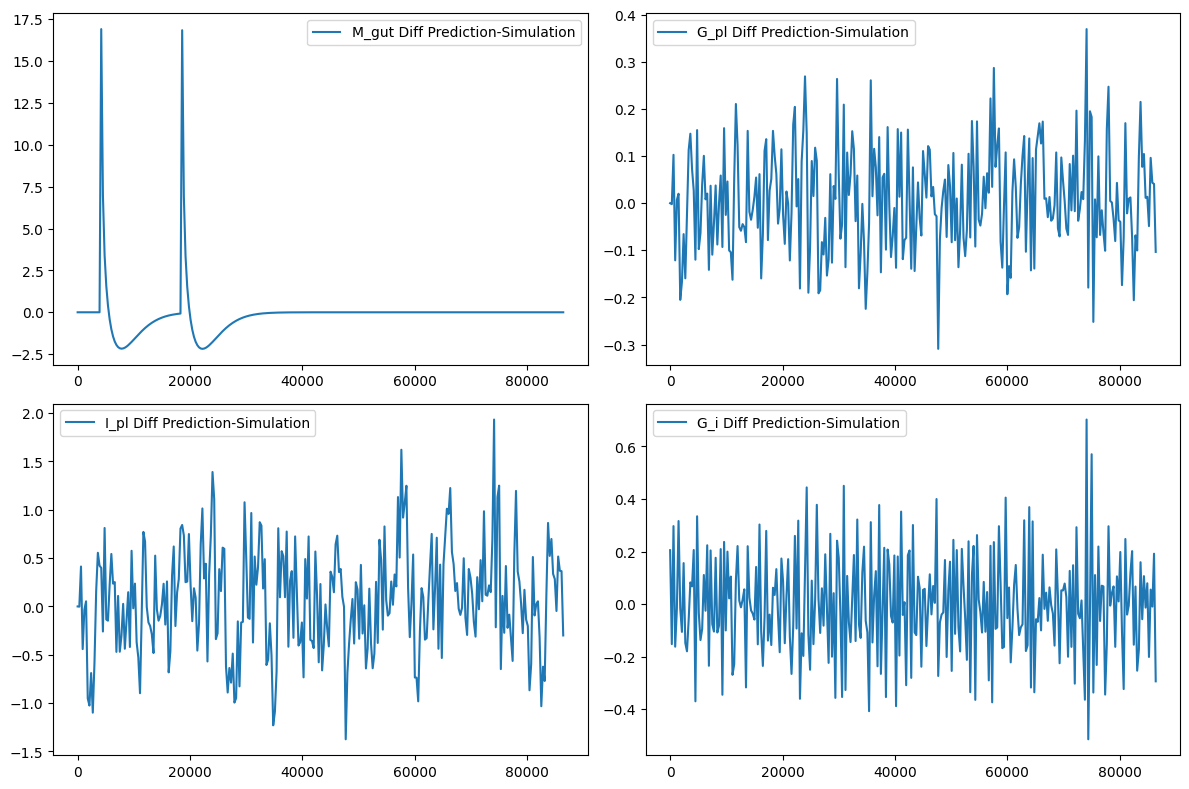

In [24]:
estimate_error(comp_pred_sim, t_eval)

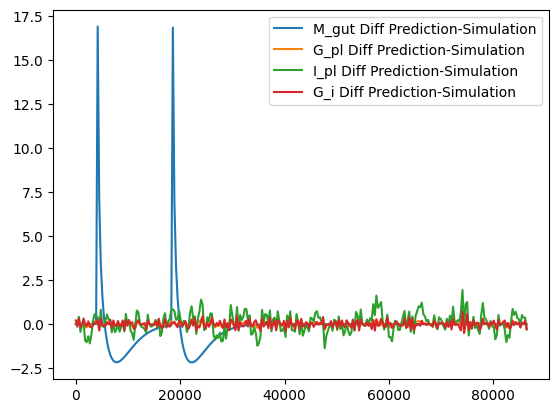

In [25]:
#Überprüfen, wie gross der Unterschied zwischen Simulation und Vorhersage ist
plt.plot(t_eval, comp_pred_sim[:,0], label = "M_gut Diff Prediction-Simulation")
plt.plot(t_eval, comp_pred_sim[:,1], label = "G_pl Diff Prediction-Simulation")
plt.plot(t_eval, comp_pred_sim[:,2], label = "I_pl Diff Prediction-Simulation")
plt.plot(t_eval, comp_pred_sim[:,3], label = "G_i Diff Prediction-Simulation")
plt.legend()

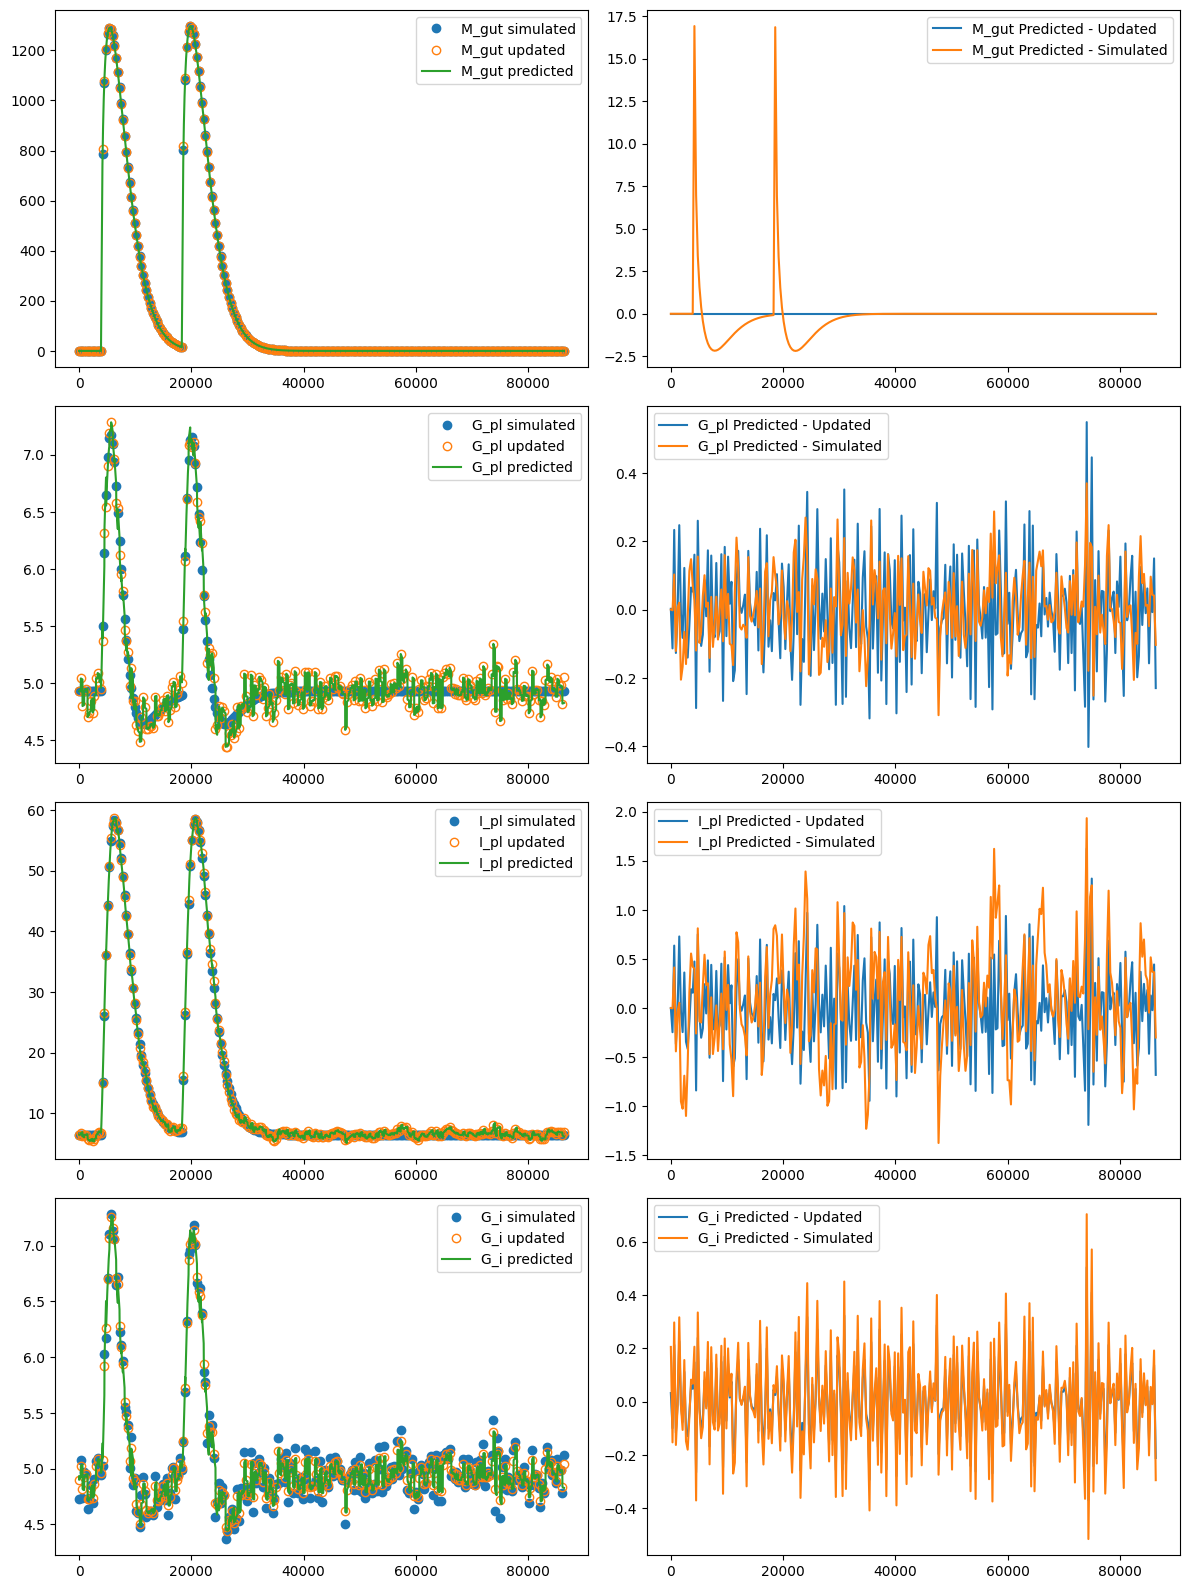

In [26]:
plot_ukf(sim, x_upd, x_pred, t_eval, time_pred)

In [27]:
x_pred[-1]

array([-6.87789256e-16,  4.82663308e+00,  6.19966248e+00,  4.82688533e+00,
        2.24999994e-05,  1.26666664e-05,  2.99999994e+01])

In [28]:
k1_pred = param.k1+x_pred[:,4]
k5_pred = param.k5+x_pred[:,5]
tau_g_pred = param.tau_g+x_pred[:,6]
min_k1, max_k1, min_k5, max_k5, min_tau_g, max_tau_g = np.min(k1_pred), np.max(k1_pred), np.min(k5_pred), np.max(k5_pred), np.min(tau_g_pred), np.max(tau_g_pred)
startdiff_k1 = (delta_k1+param.k1)/k1_pred[-1] 
startdiff_k5 = (delta_k5+param.k5)/k5_pred[-1] 
startdiff_tau_g = (delta_tau_g+param.tau_g)/tau_g_pred[-1] 

print(f"(Max, Min) k1: ({max_k1}, {min_k1}), (Max, Min) k5: ({max_k5}, {min_k5}), (Max, Min) tau_g: ({max_tau_g}, {min_tau_g})")
print(f"k1_sim/k1_pred = {startdiff_k1}, k5_sim/k5_pred = {startdiff_k5}, tau_g_sim/tau_g_pred = {startdiff_tau_g}")

(Max, Min) k1: (0.00024749999999248686, 0.00024749999940162616), (Max, Min) k5: (7.59999999966635e-05, 7.599999969912372e-05), (Max, Min) tau_g: (180.00000001117587, 179.99999938439578)
k1_sim/k1_pred = 1.000000002417672, k5_sim/k5_pred = 1.000000003953055, tau_g_sim/tau_g_pred = 1.0000000034122625


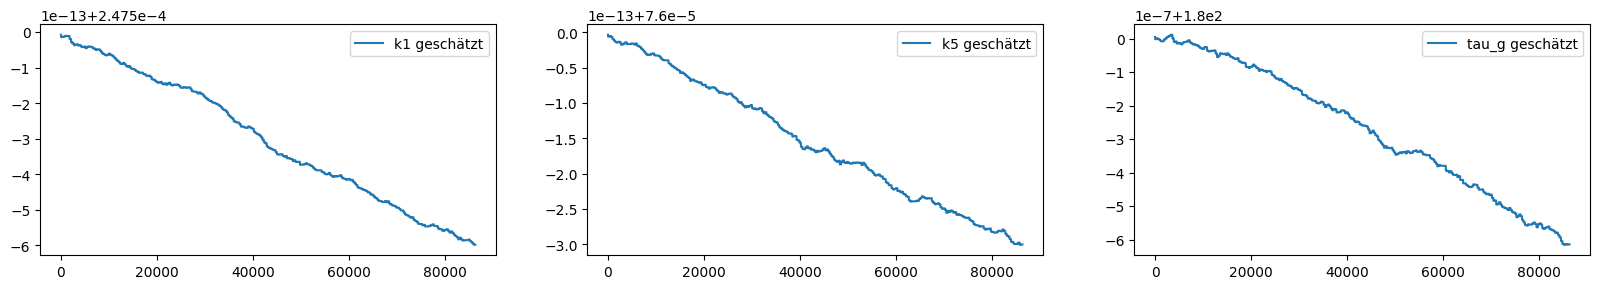

In [29]:
fig, ax = plt.subplots(1,3, figsize = (20,3))

ax[0].plot(time_pred, k1_pred, label = "k1 geschätzt")
ax[0].legend()

ax[1].plot(time_pred, k5_pred, label = "k5 geschätzt")
ax[1].legend()

ax[2].plot(time_pred, tau_g_pred, label = "tau_g geschätzt")
ax[2].legend()

### UKF-Schätzung von Parameter k1 - tangens-reparametrisiert

In [30]:
def iterate_euler_k1(y_in: np.ndarray, delta_t: float, inputs: tuple):
    '''Euler-Approximation der Integrationsfunktionen für EDES-Gleichungen'''
    t_current, D_meal = inputs
    y_next = np.zeros(len(y_in))
    dydt = f_odes_Dt_tan_k1(y_in, t_current, D_meal)
    y_next = y_in + dydt*delta_t
    return y_next

In [31]:
#Prozessrauschen
Q_4sk1 = np.diag([
    1e-4,   # M_gut
    5e-3,   # G_pl
    5e-4,   # I_pl
    5e-3,   # G_i
    5e-4, # p_k1
])

In [32]:
#Kovarianzmatrix
# Schätzung von Varianzen mithilfe von Erlandsen-Paper (CV - Werte von Parametern mit ähnlicher Funktionalität) & ChatGPT
# CV = σ / μ
# var = σ^2

var_M_gut = 4 # Empfehlung ChatGPT
var_G_pl = ((0.027+0.077+0.027)/3*param.G_pl_b)**2 # CV-Werte für basale Glukose
var_I_pl = ((0.35+0.72)/2*param.I_pl_b)**2 # CV-Werte für Basales Insulin
var_G_i = var_G_pl*0.9 # Meine Annahme: Etwas kleinere Unsicherheit als Basal-Glukose
var_k1 = 0.5*param.k1**2 # Empfehlung ChatGPT
var_k5 = 0.5*param.k5**2 # Empfehlung ChatGPT
var_tau_g = (0.2*param.tau_g)**2 # Empfehlung ChatGPT

In [33]:
var_G_pl, np.sqrt(var_G_pl), np.sqrt(var_I_pl)

(0.0463440432111111, 0.21527666666666664, 3.4774999999999996)

In [34]:
#Kovarianz-Matrix P
covar_4sk1 = np.diag([
    var_M_gut, #M_gut
    var_G_pl, #G_pl
    var_I_pl, #I_pl
    var_G_i, #G_i 
    0.8, # p_k1
])

In [35]:
a_k1, b_k1 = 1e-7/60, 3e-1/60 #lower und upper bound für Parameter k1

In [36]:
#Startwert p_k1 für k1 berechnen
#Ziel: UKF soll k1 schätzen, die anderen Parameter bleiben ungeschätzt (fix codiert in der Gleichungsfunktion)
#Die Schätzung erfolgt über einen unbeschränkten Hilfsparameter p_k1, der mittels einer 
#arctan-basierten Reparametrisierung auf den beschränkten Parameter k1∈[a_k1,b_k1] abgebildet wird.
# k1 = (b_k1 - a_k1)/pi * atan(p_k1) + (a_k1 + b_k1)/2, mit a_k1, b_k1 = lower und upper bound
# daraus folgt: p_k1 = pi(tan(k1) - tan((a_k1+b_k1)/2))/(b_k1-a_k1) für den Startwert von p_k1

p_k1 = np.pi*(np.tan(param.k1+delta_k1)-np.tan((a_k1+b_k1)/2))/(b_k1-a_k1) #p_k1 für simulatiertes k1
#p_k1 = np.pi*(np.tan(param.k1)-np.tan((a_k1+b_k1)/2))/(b_k1-a_k1) #p_k1 für k1 = Literaturwert
p_k1

-1.4152917551334008

In [37]:
y_4sk1 = np.array([0, #M_gut_start
            G_start, #G_pl_start
            I_start, #I_pl_start
            G_start, #G_i_start
            p_k1]) #parametrisierter Startwert für k1

In [38]:
#num_states, process_noise, initial_state, initial_covar, alpha, k, beta, iterate_function
params_4sk1 = {
    "num_states" : 5,
    "process_noise" : Q_4sk1,
    "initial_state" : y_4sk1,
    "initial_covar" : covar_4sk1,
    "alpha" : 1e-3, #Standardwert
    "k": 0, #Standardwert
    "beta" : 2.0, # Standardwert
    "iterate_function" : iterate_euler_k1
}

In [39]:
#UKF für 4 Zustände, Parameter k1
estimator_4sk1 = UKF(**params_4sk1)

#Schrittgrösse
step_4sk1 = 10 #in [s]
x_pred_4sk1 = np.zeros((int(24*3600/step_4sk1 + 1),5))
x_upd_4sk1 = np.zeros((len(data),5))
time_4sk1 = np.arange(1, 24*3600+2, step_4sk1)

In [40]:
#Schätzen der 4 Zustände und k1
t_current = 1
data_count = 0
R = np.array([[0.2]])

for i in range(0, len(x_pred_4sk1)):
    inputs = (t_current, D_in_mealtime)  #Zeitpunkt der Mahlzeit und Mahlzeitengrösse in tuple speichern
    estimator_4sk1.predict(step_4sk1, inputs) #Modellvorhersage
    x_pred_4sk1[i] = estimator_4sk1.get_state() #Zustand speichern
    
    if t_current == data[data_count,0]:
        cgm = data[data_count, 1] #CGM-Daten auslesen
        estimator_4sk1.update([3], cgm, R)
        x_upd_4sk1[data_count] = estimator_4sk1.get_state()
        data_count += 1

    t_current += step_4sk1

In [41]:
sim_4sk1 = sim[:,0:5]
np.shape(sim_4sk1)

(289, 5)

In [42]:
x_pred_4sk1_masked = mask_data(time_4sk1, t_eval, x_pred_4sk1)
comp_pred_sim_4sk1 = x_pred_4sk1_masked-sim_4sk1

array([[ 3.61673267e+07,  3.09411142e+01,  9.91883663e+03,
         2.10815491e+01,  6.97359618e+03],
       [ 3.53760455e+02,  3.27204338e-01,  5.85843273e+00,
         2.70086165e-01,  4.91223886e+00],
       [ 7.77929270e+01,  1.10456820e-01,  2.21892928e+00,
         1.73231057e-01,  4.82834343e+00],
       [ 2.89283961e+01,  3.39972782e-02,  4.60228221e-01,
         1.39723141e-02, -4.82834343e+00]])

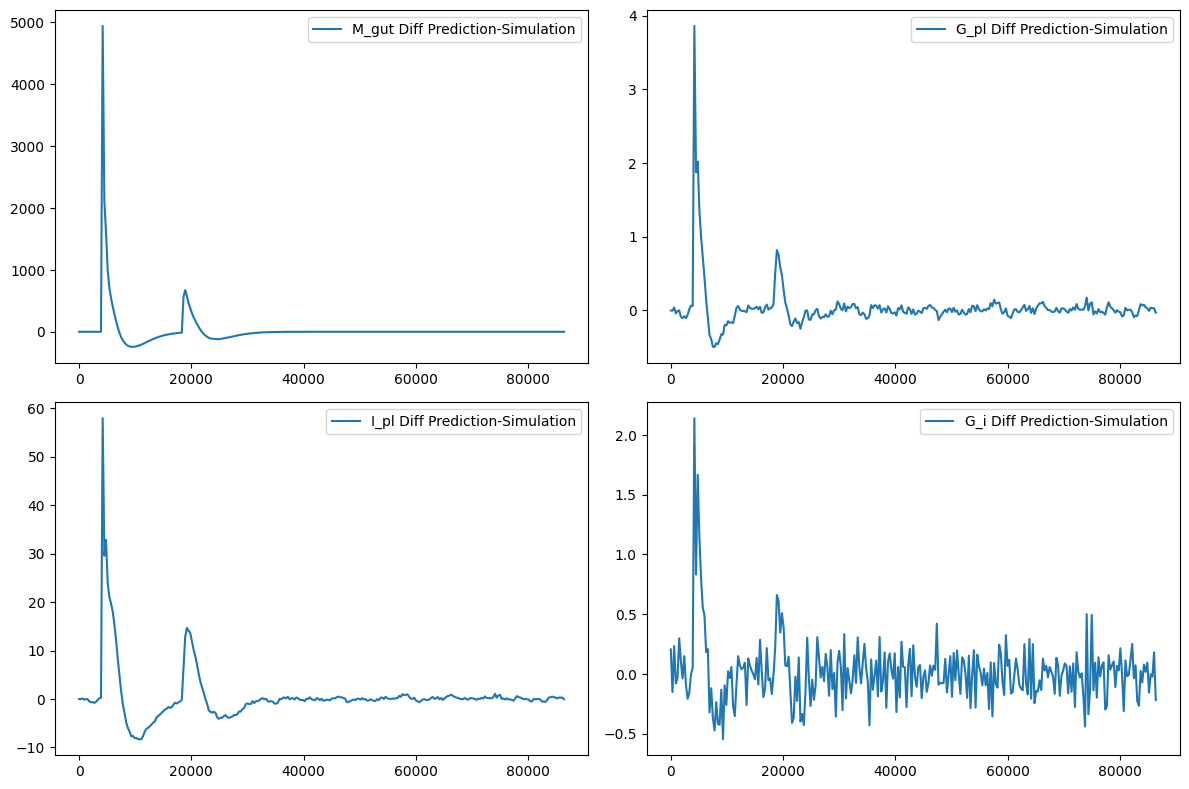

In [43]:
estimate_error(comp_pred_sim_4sk1, t_eval)
#ACHTUNG: Fehler für k1 stimmt nicht --> k1-sim enthält falsche Werte!

In [44]:
k1_MAE = np.mean(np.absolute(x_pred_4sk1[:,4]-p_k1))
k1_MAE

3.4244836215293364

In [45]:
p_k1

-1.4152917551334008

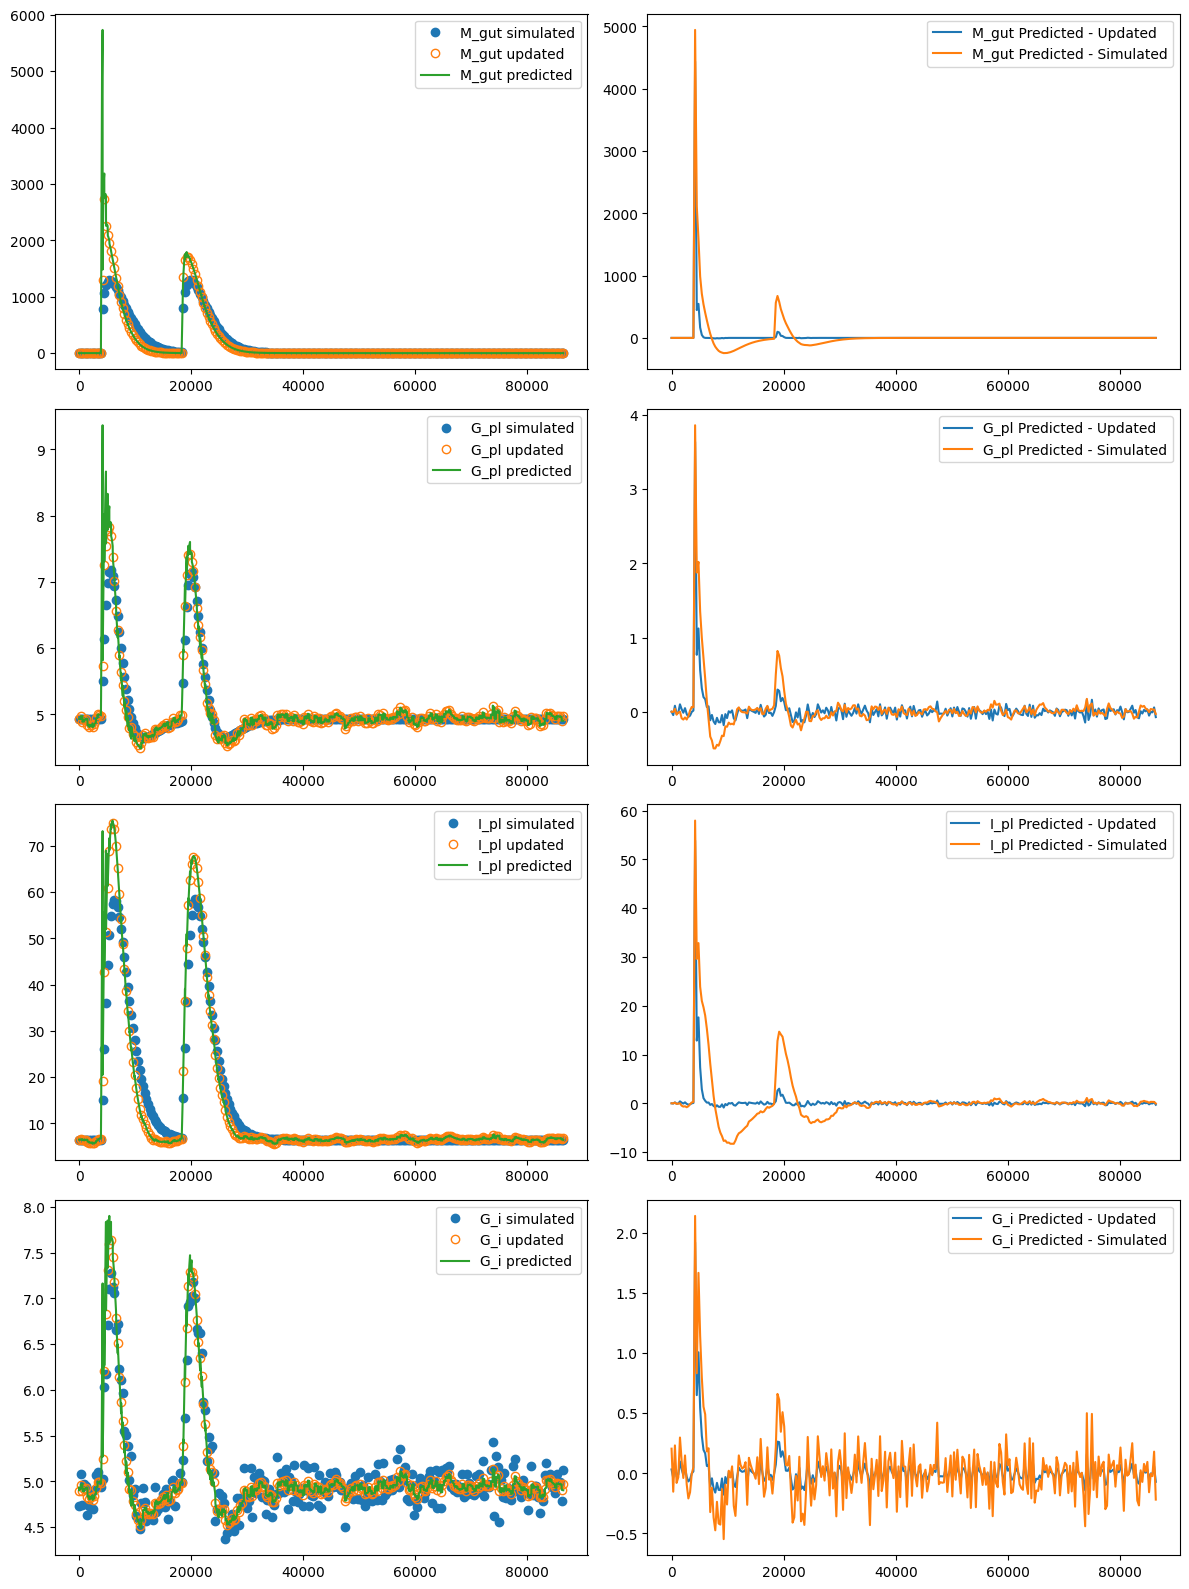

In [46]:
plot_ukf(sim_4sk1, x_upd_4sk1, x_pred_4sk1, t_eval, time_4sk1)

In [47]:
k1_est = (a_k1 + b_k1)/2 + (b_k1 - a_k1)/np.pi*np.arctan(x_pred_4sk1[:,4])

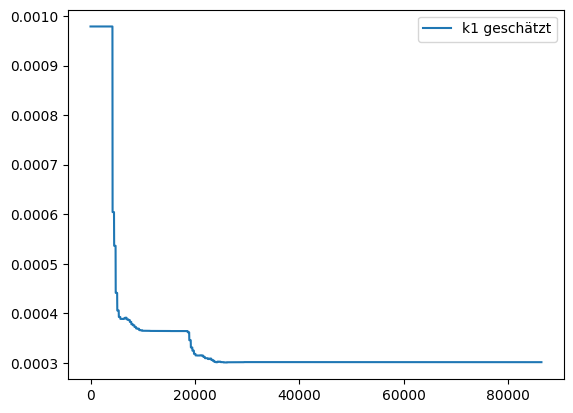

In [48]:
#zeitlicher Verlauf der UKF Schätzung für k1
plt.plot(time_4sk1, k1_est, label = "k1 geschätzt")
plt.legend()

In [49]:
min_k1, max_k1 = np.min(k1_est), np.max(k1_est)
err_k1 = (delta_k1+param.k1)/k1_est[-1] #Vergleich Schätzung mit tatsächlichem Wert
rel_err_k1 = (k1_est[-1]-(delta_k1+param.k1))/(delta_k1+param.k1)

print(f"(Max, Min) k1: ({max_k1}, {min_k1})")
print(f"Parameter der Simulation/ Parameter geschätzt: k1_sim/k1_pred = {err_k1}")
print(f"Relativer Fehler = {rel_err_k1}")

(Max, Min) k1: (0.0009789960122032937, 0.0003005524892873454)
Parameter der Simulation/ Parameter geschätzt: k1_sim/k1_pred = 0.8217652822277378
Relativer Fehler = 0.21689248940899833


### UKF Schätzung nur tau_g

In [50]:
def iterate_euler_taug(y_in: np.ndarray, delta_t: float, inputs: tuple):
    '''Euler-Approximation der Integrationsfunktionen für EDES-Gleichungen'''
    t_current, D_meal = inputs
    y_next = np.zeros(len(y_in))
    dydt = f_odes_Dt_tan_taug(y_in, t_current, D_meal)
    y_next = y_in + dydt*delta_t
    return y_next

In [51]:
#Prozessrauschen
Q_4staug = np.diag([
    1e-4,   # M_gut
    5e-3,   # G_pl
    5e-4,   # I_pl
    5e-3,   # G_i
    5e-4, # p_tau_g
])

In [52]:
#Kovarianz-Matrix P
covar_4staug = np.diag([
    var_M_gut, #M_gut
    var_G_pl, #G_pl
    var_I_pl, #I_pl
    var_G_i, #G_i 
    5, # p_tau_g
])

In [53]:
a_taug, b_taug = (1e-10)*60, 20*60 #lower und upper bound für Parameter tau_g

In [54]:
#Startwert p_taug für taug berechnen
#Ziel: UKF soll taug schätzen, die anderen Parameter bleiben ungeschätzt (fixe Werte in der Gleichungsfunktion)
#Die Schätzung erfolgt über einen unbeschränkten Hilfsparameter p_taug, der mittels einer 
#arctan-basierten Reparametrisierung auf den beschränkten Parameter taug∈[a_taug,b_taug] abgebildet wird.
# taug = (b_taug - a_taug)/pi * atan(p_taug) + (a_taug + b_taug)/2, mit a_taug, b_taug = lower und upper bound
# daraus folgt: p_taug = pi(tan(taug) - tan((a_taug+b_taug)/2))/(b_taug-a_taug) für den Startwert von p_taug

#p_taug = np.pi*(np.tan(param.tau_g+delta_tau_g)-np.tan((a_taug+b_taug)/2))/(b_taug-a_taug) #p_k1 für simulatiertes k1
p_taug = np.pi*(np.tan(param.tau_g)-np.tan((a_taug+b_taug)/2))/(b_taug-a_taug) #p_taug für tau_g = Literaturwert
p_taug

-0.002560713750188566

In [55]:
y_4staug = np.array([0, #M_gut_start
            G_start, #G_pl_start
            I_start, #I_pl_start
            G_start, #G_i_start
            p_taug]) #parametrisierter Startwert für taug

In [56]:
#num_states, process_noise, initial_state, initial_covar, alpha, k, beta, iterate_function
params_4staug = {
    "num_states" : 5,
    "process_noise" : Q_4staug,
    "initial_state" : y_4staug,
    "initial_covar" : covar_4staug,
    "alpha" : 1e-3, #Standardwert
    "k": 0, #Standardwert
    "beta" : 2.0, # Standardwert
    "iterate_function" : iterate_euler_taug
}

In [ ]:
#UKF für 4 Zustände, taug
estimator_4staug = UKF(**params_4staug)

#Schrittgrösse
step_4staug = 10 #in [s]
x_pred_4staug = np.zeros((int(24*3600/step_4staug + 1),5))
x_upd_4staug = np.zeros((len(data),5))
time_4staug = np.arange(1, 24*3600+2, step_4staug)

In [ ]:
#Schätzen der 4 Zustände und taug
t_current = 1
data_count = 0
R = np.array([[0.2]])

for i in range(0, len(x_pred_4staug)):
    inputs = (t_current, D_in_mealtime)  #Zeitpunkt der Mahlzeit und Mahlzeitengrösse in tuple speichern
    estimator_4staug.predict(step_4staug, inputs) #Modellvorhersage
    x_pred_4staug[i] = estimator_4staug.get_state() #Zustand speichern
    
    if t_current == data[data_count,0]:
        cgm = data[data_count, 1] #CGM-Daten auslesen
        estimator_4staug.update([3], cgm, R)
        x_upd_4staug[data_count] = estimator_4staug.get_state()
        data_count += 1

    t_current += step_4staug

In [59]:
sim_4staug = sim[:, [0, 1, 2, 3, 6]]
np.shape(sim_4staug)

(289, 5)

In [60]:
#Die Ausgabe in Simulation enthält nur die Differenz zum Literaturwert. 
#Für eine korrekte Berechnung des Fehlerwerts muss also das simulierte tau_g reparametrisiert werden,
#damit es mit der Ausgabe des UKF verglichen werden kann.
#sim_4staug[:,4]= param.tau_g+delta_tau_g #effektives tau_g der Simulation berechnen
sim_4staug[:,4]= param.tau_g #effektives tau_g des Literaturwerts einfügen
sim_4staug[:,4] = np.pi*(np.tan(sim_4staug[:,4])-np.tan((a_taug+b_taug)/2))/(b_taug-a_taug) #mit reparametrisiertem Wert ersetzen

In [61]:
x_pred_4staug_masked = mask_data(time_4staug, t_eval, x_pred_4staug)
comp_pred_sim_4staug = x_pred_4staug_masked-sim_4staug

In [62]:
x_pred_4staug_masked[-1, 4], sim_4staug[-1, 4], sim_4staug[0,4]

(-1.6314621719066054, -0.002560713750188566, -0.002560713750188566)

array([[ 8.25314087e+02,  8.78105605e-01,  4.55909707e+01,
         8.26280149e+00,  6.15884309e+02],
       [ 1.68989884e+00,  5.51219348e-02,  3.97182859e-01,
         1.69088760e-01,  1.45982450e+00],
       [ 4.98483327e-01,  4.38963803e-02,  3.06154808e-01,
         1.34953029e-01,  1.40326046e+00],
       [-9.50846530e-02,  4.06438511e-03,  3.69334470e-02,
        -4.43538643e-03, -1.40211898e+00]])

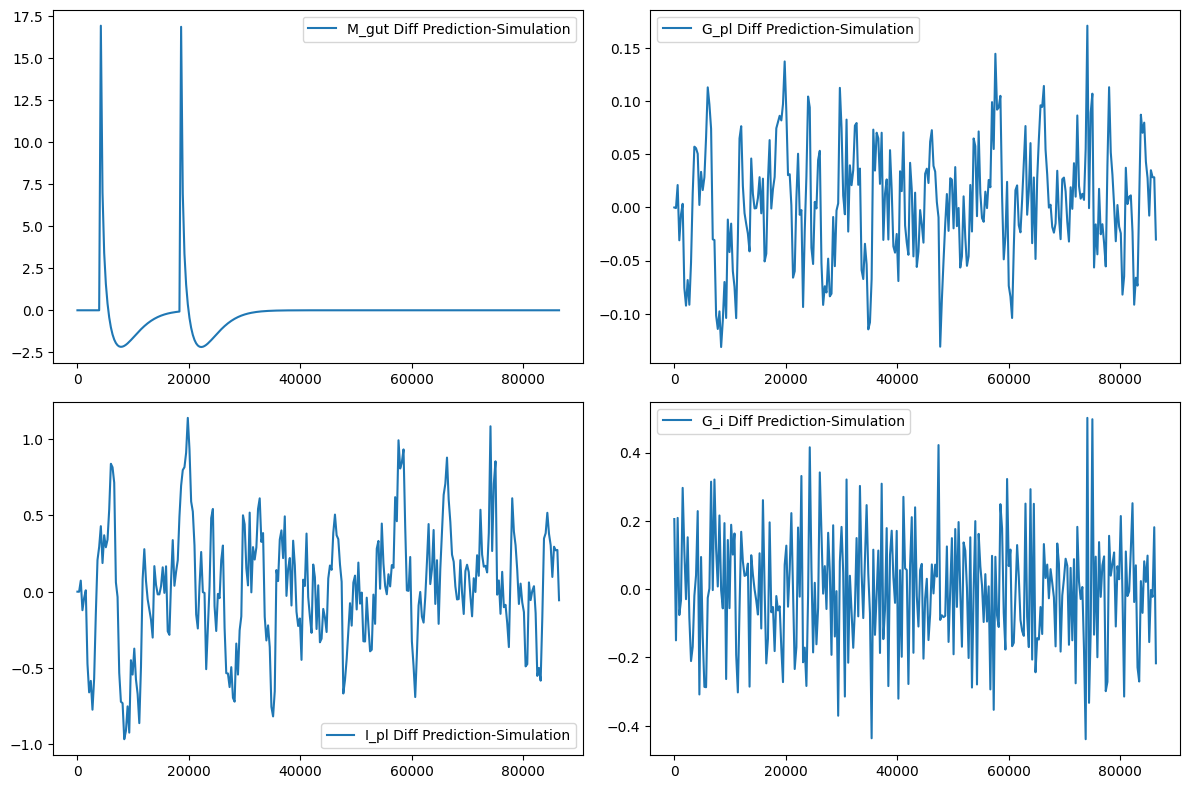

In [63]:
estimate_error(comp_pred_sim_4staug, t_eval)

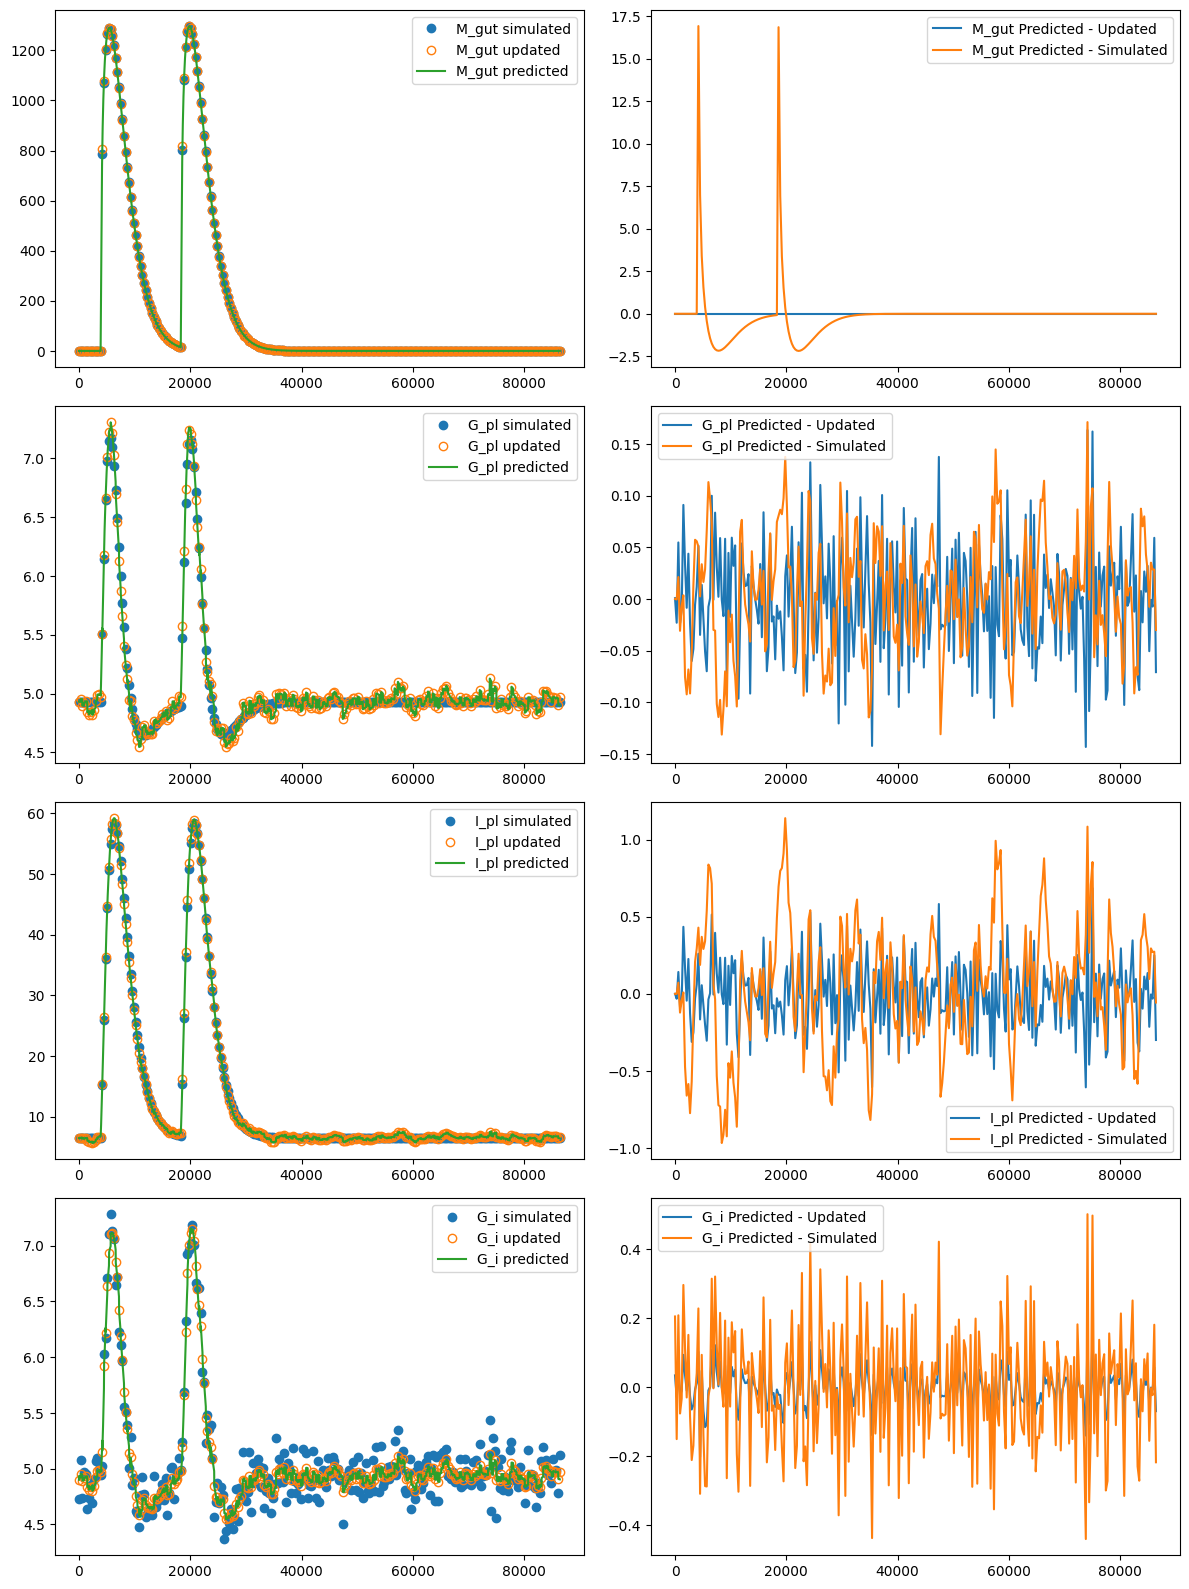

In [64]:
plot_ukf(sim_4staug, x_upd_4staug, x_pred_4staug, t_eval, time_4staug)

In [65]:
#geschätztes tau_g umrechnen in Zeitformat
taug_est = (a_taug + b_taug)/2 + (b_taug - a_taug)/np.pi*np.arctan(x_pred_4staug[:,4])

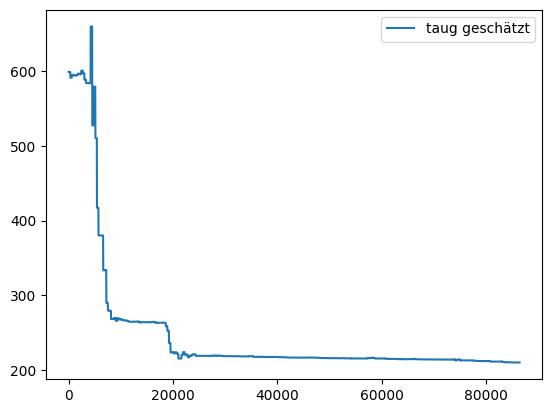

In [66]:
plt.plot(time_4staug, taug_est, label = "taug geschätzt")
plt.legend()

In [67]:
min_taug, max_taug = np.min(taug_est), np.max(taug_est)
err_taug = (delta_tau_g+param.tau_g)/taug_est[-1] #Vergleich Schätzung mit tatsächlichem Wert der Simulation
rel_err_taug = (taug_est[-1]-(delta_tau_g+param.tau_g))/(delta_tau_g+param.tau_g)

print(f"(Max, Min) tau_g: ({max_taug}, {min_taug})")
print(f"Parameter der Simulation/ Parameter geschätzt: tau_g_sim/tau_g_pred = {err_taug}")
print(f"Relativer Fehler: {rel_err_taug}")

(Max, Min) tau_g: (659.8199799371613, 210.04062575382056)
Parameter der Simulation/ Parameter geschätzt: tau_g_sim/tau_g_pred = 0.8569770698120569
Relativer Fehler: 0.16689236529900314


### UKF Schätzung - nur k5

In [69]:
from Test_UKF_ode_Dt_tan_k5 import f_odes_Dt_tan_k5

In [70]:
def iterate_euler_k5(y_in: np.ndarray, delta_t: float, inputs: tuple):
    '''Euler-Approximation der Integrationsfunktionen für EDES-Gleichungen'''
    t_current, D_meal = inputs
    y_next = np.zeros(len(y_in))
    dydt = f_odes_Dt_tan_k5(y_in, t_current, D_meal)
    y_next = y_in + dydt*delta_t
    return y_next

In [71]:
#Prozessrauschen
Q_4sk5 = np.diag([
    1e-4,   # M_gut
    5e-3,   # G_pl
    5e-4,   # I_pl
    5e-3,   # G_i
    5e-4, # p_k5
])

In [72]:
#Kovarianz-Matrix P
covar_4sk5 = np.diag([
    var_M_gut, #M_gut
    var_G_pl, #G_pl
    var_I_pl, #I_pl
    var_G_i, #G_i 
    125, # p_k5
])

In [73]:
#Bounds für k5 (Erdös (2024))
a_k5, b_k5 = 1e-7/60, 1.0/60

In [74]:
#Startwert p_k5 für k5 berechnen
#Ziel: UKF soll k5 schätzen, die anderen Parameter bleiben ungeschätzt (fixe Werte in der Gleichungsfunktion)
#Die Schätzung erfolgt über einen unbeschränkten Hilfsparameter p_k5, der mittels einer 
#arctan-basierten Reparametrisierung auf den beschränkten Parameter taug∈[a_taug,b_taug] abgebildet wird.
# taug = (b_taug - a_taug)/pi * atan(p_taug) + (a_taug + b_taug)/2, mit a_taug, b_taug = lower und upper bound
# daraus folgt: p_taug = pi(tan(taug) - tan((a_taug+b_taug)/2))/(b_taug-a_taug) für den Startwert von p_taug

p_k5 = np.pi*(np.tan(param.k5+delta_k5)-np.tan((a_k5+b_k5)/2))/(b_k5-a_k5) #p_k1 für simulatiertes k1
#p_k5 = np.pi*(np.tan(param.k5)-np.tan((a_k5+b_k5)/2))/(b_k5-a_k5) #p_taug für tau_g = Literaturwert
p_k5

-1.5565073390443607

In [75]:
y_4sk5 = np.array([0, #M_gut_start
            G_start, #G_pl_start
            I_start, #I_pl_start
            G_start, #G_i_start
            p_k5]) #parametrisierter Startwert für k5

In [76]:
#num_states, process_noise, initial_state, initial_covar, alpha, k, beta, iterate_function
params_4sk5 = {
    "num_states" : 5,
    "process_noise" : Q_4sk5,
    "initial_state" : y_4sk5,
    "initial_covar" : covar_4sk5,
    "alpha" : 1e-3, #Standardwert
    "k": 0, #Standardwert
    "beta" : 2.0, # Standardwert
    "iterate_function" : iterate_euler_k5
}

In [77]:
#UKF für 4 Zustände, k5
estimator_4sk5 = UKF(**params_4sk5)

#Schrittgrösse
step_4sk5 = 10 #in [s]
x_pred_4sk5 = np.zeros((int(24*3600/step_4sk5 + 1),5))
x_upd_4sk5 = np.zeros((len(data),5))
time_4sk5 = np.arange(1, 24*3600+2, step_4sk5)

In [78]:
#Schätzen der 4 Zustände und k5
t_current = 1
data_count = 0
R = np.array([[0.2]])

for i in range(0, len(x_pred_4sk5)):
    inputs = (t_current, D_in_mealtime)  #Zeitpunkt der Mahlzeit und Mahlzeitengrösse in tuple speichern
    estimator_4sk5.predict(step_4sk5, inputs) #Modellvorhersage
    x_pred_4sk5[i] = estimator_4sk5.get_state() #Zustand speichern
    
    if t_current == data[data_count,0]:
        cgm = data[data_count, 1] #CGM-Daten auslesen
        estimator_4sk5.update([3], cgm, R)
        x_upd_4sk5[data_count] = estimator_4sk5.get_state()
        data_count += 1

    t_current += step_4sk5

In [79]:
sim_4sk5 = sim[:, [0, 1, 2, 3, 5]]
np.shape(sim_4sk5)

(289, 5)

In [80]:
#Spalte 4 mit dem parametrisierten Wert von k5 ersetzen
#Die Ausgabe in Simulation enthält nur die Differenz zum Literaturwert. 
#Für eine korrekte Berechnung des Fehlerwerts muss also das simulierte k5 reparametrisiert werden,
#damit es mit der Ausgabe des UKF verglichen werden kann.
sim_4sk5[:,4]= param.k5+delta_k5 #effektives k5 der Simulation berechnen
#sim_4sk5[:,4]= param.k5 #effektives k5 des Literaturwerts einfügen
sim_4sk5[:,4] = np.pi*(np.tan(sim_4sk5[:,4])-np.tan((a_k5+b_k5)/2))/(b_k5-a_k5) #mit reparametrisiertem Wert ersetzen

In [81]:
x_pred_4sk5_masked = mask_data(time_4sk5, t_eval, x_pred_4sk5)
comp_pred_sim_4sk5 = x_pred_4sk5_masked-sim_4sk5

In [82]:
x_pred_4sk5_masked[-1, 4], sim_4sk5[-1, 4], sim_4sk5[0,4]

(-36.30833461601287, -1.5565073390443607, -1.5565073390443607)

array([[ 8.25314090e+02,  1.48322029e+01,  1.77010434e+04,
         1.76079346e+01,  2.97852201e+05],
       [ 1.68989884e+00,  2.26544701e-01,  7.82619224e+00,
         2.46834174e-01,  3.21034337e+01],
       [ 4.98483322e-01,  9.51632509e-02,  3.30573633e+00,
         1.70268108e-01,  3.09137796e+01],
       [-9.50846534e-02, -3.94982090e-02, -3.17987288e+00,
        -4.17059920e-02, -3.09117642e+01]])

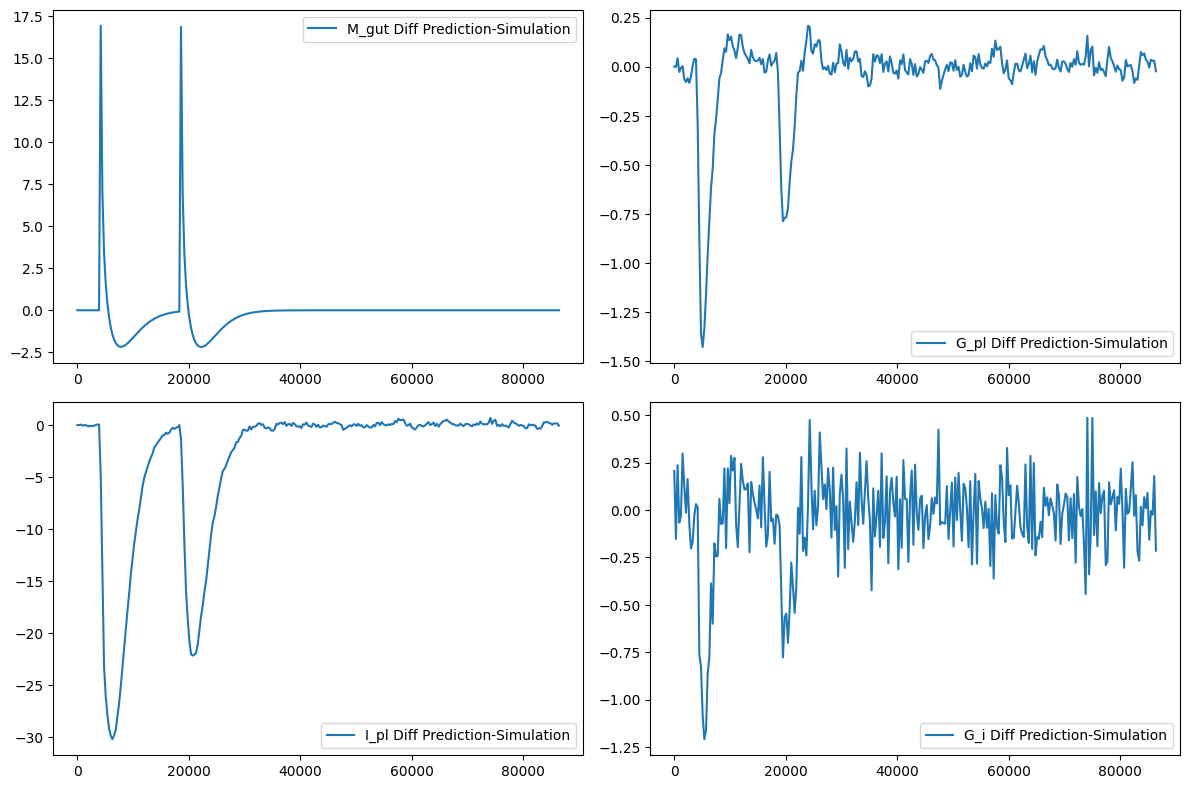

In [83]:
estimate_error(comp_pred_sim_4sk5, t_eval)

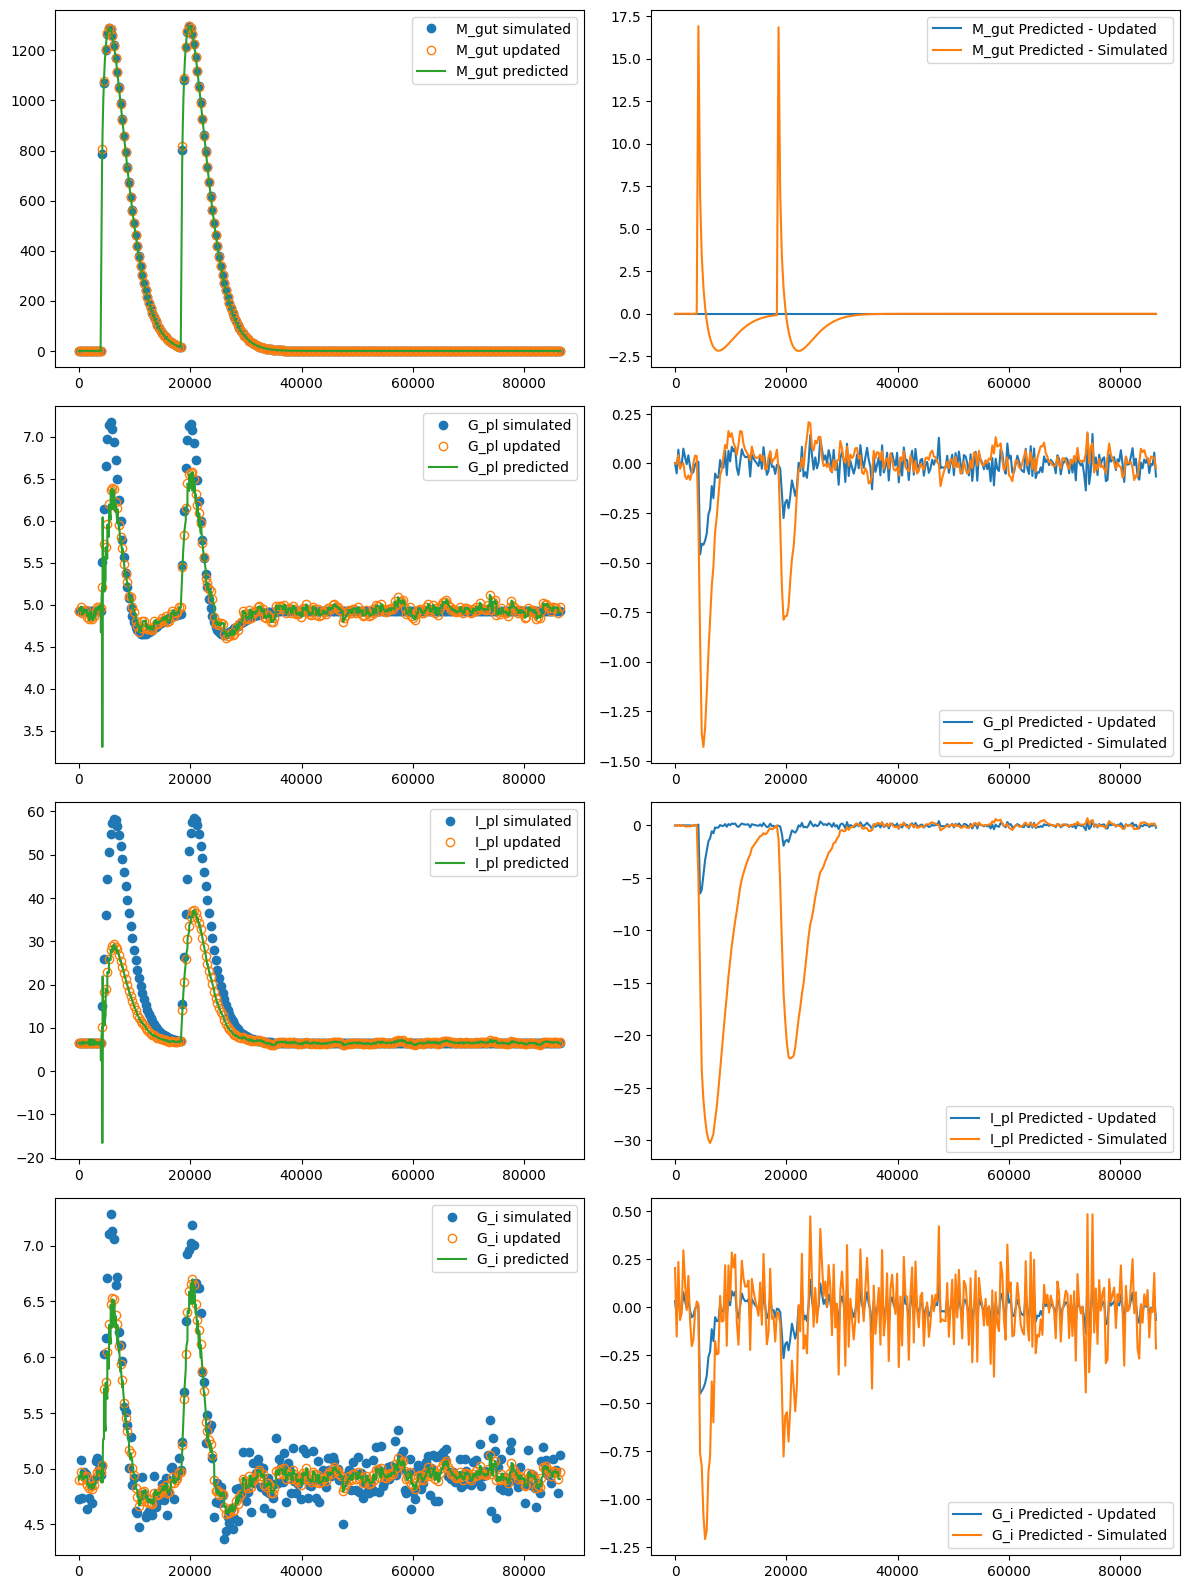

In [84]:
plot_ukf(sim_4sk5, x_upd_4sk5, x_pred_4sk5, t_eval, time_4sk5)

In [85]:
#geschätztes k5 umrechnen in Zeitformat
k5_est = (a_k5 + b_k5)/2 + (b_k5 - a_k5)/np.pi*np.arctan(x_pred_4sk5[:,4])

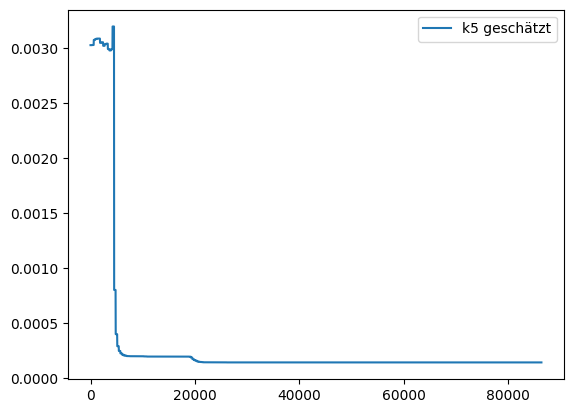

In [86]:
plt.plot(time_4sk5, k5_est, label = "k5 geschätzt")
plt.legend()

In [87]:
min_k5, max_k5 = np.min(k5_est), np.max(k5_est)
err_k5 = (delta_k5+param.k5)/k5_est[-1] #Vergleich Schätzung mit tatsächlichem Wert der Simulation

print(f"(Max, Min) k5: ({max_k5}, {min_k5})")
print(f"Parameter der Simulation/ Parameter geschätzt: k5_sim/k5_pred = {err_k5}")

(Max, Min) k5: (0.0031992090061961544, 0.00014558979776242362)
Parameter der Simulation/ Parameter geschätzt: k5_sim/k5_pred = 0.5202665557064721


In [88]:
delta_k5+param.k5

7.599999999999999e-05

### Gemeinsame Schätzung von tau_g und k1

In [90]:
from ukf_pred_upd import pred_upd
from Test_UKF_ode_Dt_tan_k1taug import f_odes_Dt_tan_k1taug

In [91]:
def iterate_euler_k1taug(y_in: np.ndarray, delta_t: float, inputs: tuple):
    '''Euler-Approximation der Integrationsfunktionen für EDES-Gleichungen'''
    t_current, D_meal = inputs
    y_next = np.zeros(len(y_in))
    dydt = f_odes_Dt_tan_k1taug(y_in, t_current, D_meal)
    y_next = y_in + dydt*delta_t
    return y_next

In [92]:
#Prozessrauschen
Q_4sk1taug = np.diag([
    1e-4,   # M_gut
    5e-3,   # G_pl
    5e-4,   # I_pl
    5e-3,   # G_i
    5e-5, # p_k1
    5e-6, # p_taug
])

#Kovarianz-Matrix P
covar_4sk1taug = np.diag([
    var_M_gut, #M_gut
    var_G_pl, #G_pl
    var_I_pl, #I_pl
    var_G_i, #G_i 
    0.0125, # p_k1
    0.000125, # p_taug
])

In [93]:
a_k1, b_k1 = 1e-7/60, 3e-1/60 #lower und upper bound für Parameter k1
a_taug, b_taug = (1e-10)*60, 20*60 #lower und upper bound für Parameter tau_g

In [94]:
#Startwert p_k1 für k1 berechnen
#Ziel: UKF soll k1 schätzen, die anderen Parameter bleiben ungeschätzt (fix codiert in der Gleichungsfunktion)
#Die Schätzung erfolgt über einen unbeschränkten Hilfsparameter p_k1, der mittels einer 
#arctan-basierten Reparametrisierung auf den beschränkten Parameter k1∈[a_k1,b_k1] abgebildet wird.
# k1 = (b_k1 - a_k1)/pi * atan(p_k1) + (a_k1 + b_k1)/2, mit a_k1, b_k1 = lower und upper bound
# daraus folgt: p_k1 = pi(tan(k1) - tan((a_k1+b_k1)/2))/(b_k1-a_k1) für den Startwert von p_k1

p_k1 = np.pi*(np.tan(param.k1+delta_k1)-np.tan((a_k1+b_k1)/2))/(b_k1-a_k1) #p_k1 für simulatiertes k1
#p_k1 = np.pi*(np.tan(param.k1)-np.tan((a_k1+b_k1)/2))/(b_k1-a_k1) #p_k1 für k1 = Literaturwert
p_k1

#Startwert p_taug für taug berechnen
#Ziel: UKF soll taug schätzen, die anderen Parameter bleiben ungeschätzt (fixe Werte in der Gleichungsfunktion)
#Die Schätzung erfolgt über einen unbeschränkten Hilfsparameter p_taug, der mittels einer 
#arctan-basierten Reparametrisierung auf den beschränkten Parameter taug∈[a_taug,b_taug] abgebildet wird.
# taug = (b_taug - a_taug)/pi * atan(p_taug) + (a_taug + b_taug)/2, mit a_taug, b_taug = lower und upper bound
# daraus folgt: p_taug = pi(tan(taug) - tan((a_taug+b_taug)/2))/(b_taug-a_taug) für den Startwert von p_taug

p_taug = np.pi*(np.tan(param.tau_g+delta_tau_g)-np.tan((a_taug+b_taug)/2))/(b_taug-a_taug) #p_k1 für simulatiertes k1
#p_taug = np.pi*(np.tan(param.tau_g)-np.tan((a_taug+b_taug)/2))/(b_taug-a_taug) #p_taug für tau_g = Literaturwert
p_taug

0.0036204652106294455

In [95]:
y_4sk1taug = np.array([0, #M_gut_start
            G_start, #G_pl_start
            I_start, #I_pl_start
            G_start, #G_i_start
            p_k1, # parametrisierter Startwert für k1
            p_taug ]) #parametrisierter Startwert für taug

In [96]:
#num_states, process_noise, initial_state, initial_covar, alpha, k, beta, iterate_function
params_4sk1taug = {
    "num_states" : 6,
    "process_noise" : Q_4sk1taug,
    "initial_state" : y_4sk1taug,
    "initial_covar" : covar_4sk1taug,
    "alpha" : 1e-3, #Standardwert
    "k": 0, #Standardwert
    "beta" : 2.0, # Standardwert
    "iterate_function" : iterate_euler_k1taug
}

In [97]:
#UKF für 4 Zustände, k1, taug
estimator_4sk1taug = UKF(**params_4sk1taug)

#Schrittgrösse
step_4sk1taug = 10 #in [s]
x_pred_4sk1taug = np.zeros((int(24*3600/step_4sk1taug + 1),6))
x_upd_4sk1taug = np.zeros((len(data),6))
time_4sk1taug = np.arange(1, 24*3600+2, step_4sk1taug)

In [98]:
# Erzeugen eines Datensets mit zwei verzögerten Mahlzeiteninputs
D_in = np.zeros(len(t_eval))
D_in[13] = D #einfügen Mahlzeiteninput
D_in[61] = D #einfügen Mahlzeiteninput
D_in_mealtime = np.column_stack((t_eval, D_in)) #Array mit Zeitpunkten & Mahlzeiteninputs

In [99]:
#UKF Schätzung für 4 Zustände + k1, k5
pred_upd(x_pred_4sk1taug, data, x_upd_4sk1taug, D_in_mealtime, estimator_4sk1taug, step_4sk1taug)

In [100]:
sim_4sk1taug = sim[:, [0,1,2,3,4,6]]
np.shape(sim_4sk1taug)

(289, 6)

In [101]:
#Spalte 4 und 5 mit dem parametrisierten Wert von k1 und taug ersetzen
#Die Ausgabe in der Simulation enthält nur die Differenz zum Literaturwert. 
#Für eine korrekte Berechnung des Fehlerwerts muss also das simulierte k1 und taug reparametrisiert werden,
#damit es mit der Ausgabe des UKF verglichen werden kann.
sim_4sk1taug[:,4]= param.k1+delta_k1 #effektives k1 der Simulation berechnen
#sim_4sk1taug[:,4]= param.k1 #effektives k1 des Literaturwerts einfügen
sim_4sk1taug[:,4] = np.pi*(np.tan(sim_4sk1taug[:,4])-np.tan((a_k1+b_k1)/2))/(b_k1-a_k1) #mit reparametrisiertem Wert ersetzen

sim_4sk1taug[:,5]= param.tau_g+delta_tau_g #effektives k5 der Simulation berechnen
#sim_4sk1taug[:,5]= param.tau_g #effektives k5 des Literaturwerts einfügen
sim_4sk1taug[:,5] = np.pi*(np.tan(sim_4sk1taug[:,5])-np.tan((a_taug+b_taug)/2))/(b_taug-a_taug) #mit reparametrisiertem Wert ersetzen

In [102]:
x_pred_4sk1taug_masked = mask_data(time_4sk1taug, t_eval, x_pred_4sk1taug)
comp_pred_sim_4sk1taug = x_pred_4sk1taug_masked-sim_4sk1taug

array([[ 7.41538462e+07,  1.69828008e+02,  6.49776498e+04,
         4.34490949e+01,  3.94972246e+02,  7.82882089e-01],
       [ 5.06544868e+02,  7.66576916e-01,  1.49945376e+01,
         3.87740750e-01,  1.16905345e+00,  5.20474261e-02],
       [ 1.62733145e+02,  2.75017968e-01,  5.80378926e+00,
         2.28244662e-01,  1.10796812e+00,  4.87609365e-02],
       [ 1.40390889e+01,  2.01629945e-02,  4.00508072e-01,
         4.90745021e-03, -1.10796812e+00,  4.87607611e-02]])

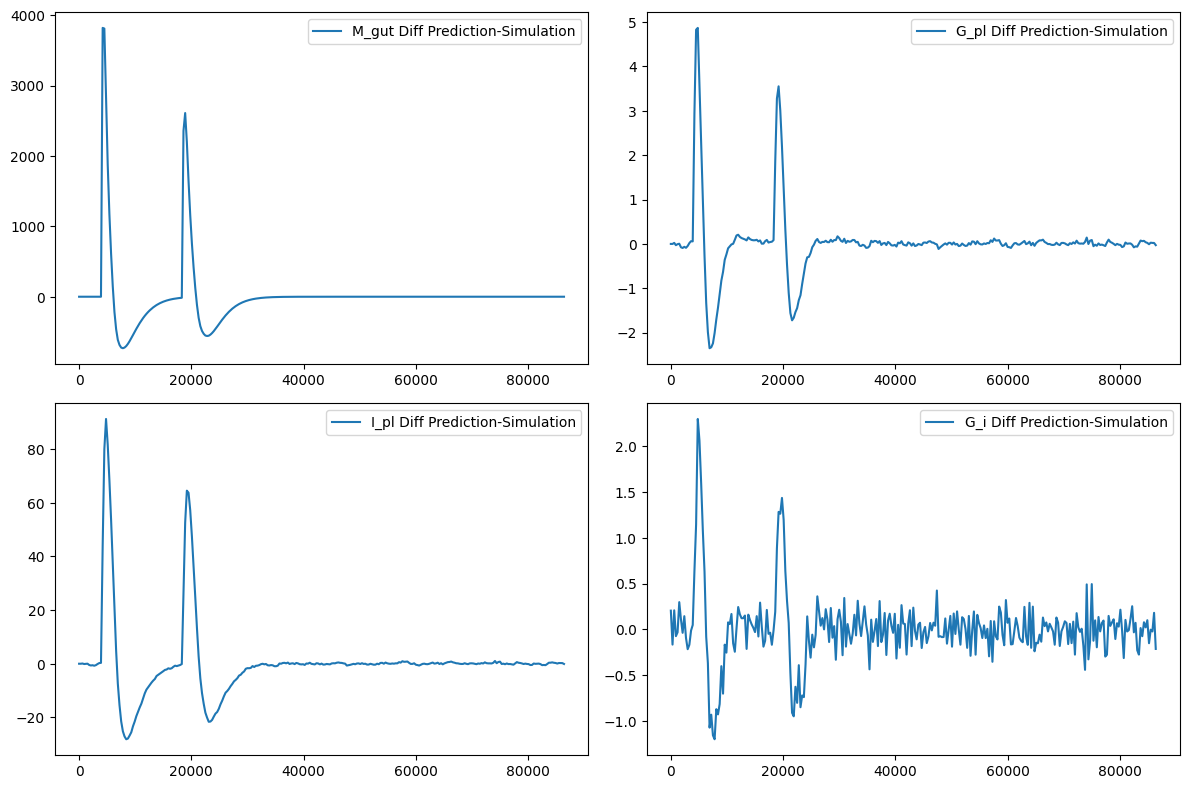

In [103]:
estimate_error(comp_pred_sim_4sk1taug, t_eval)

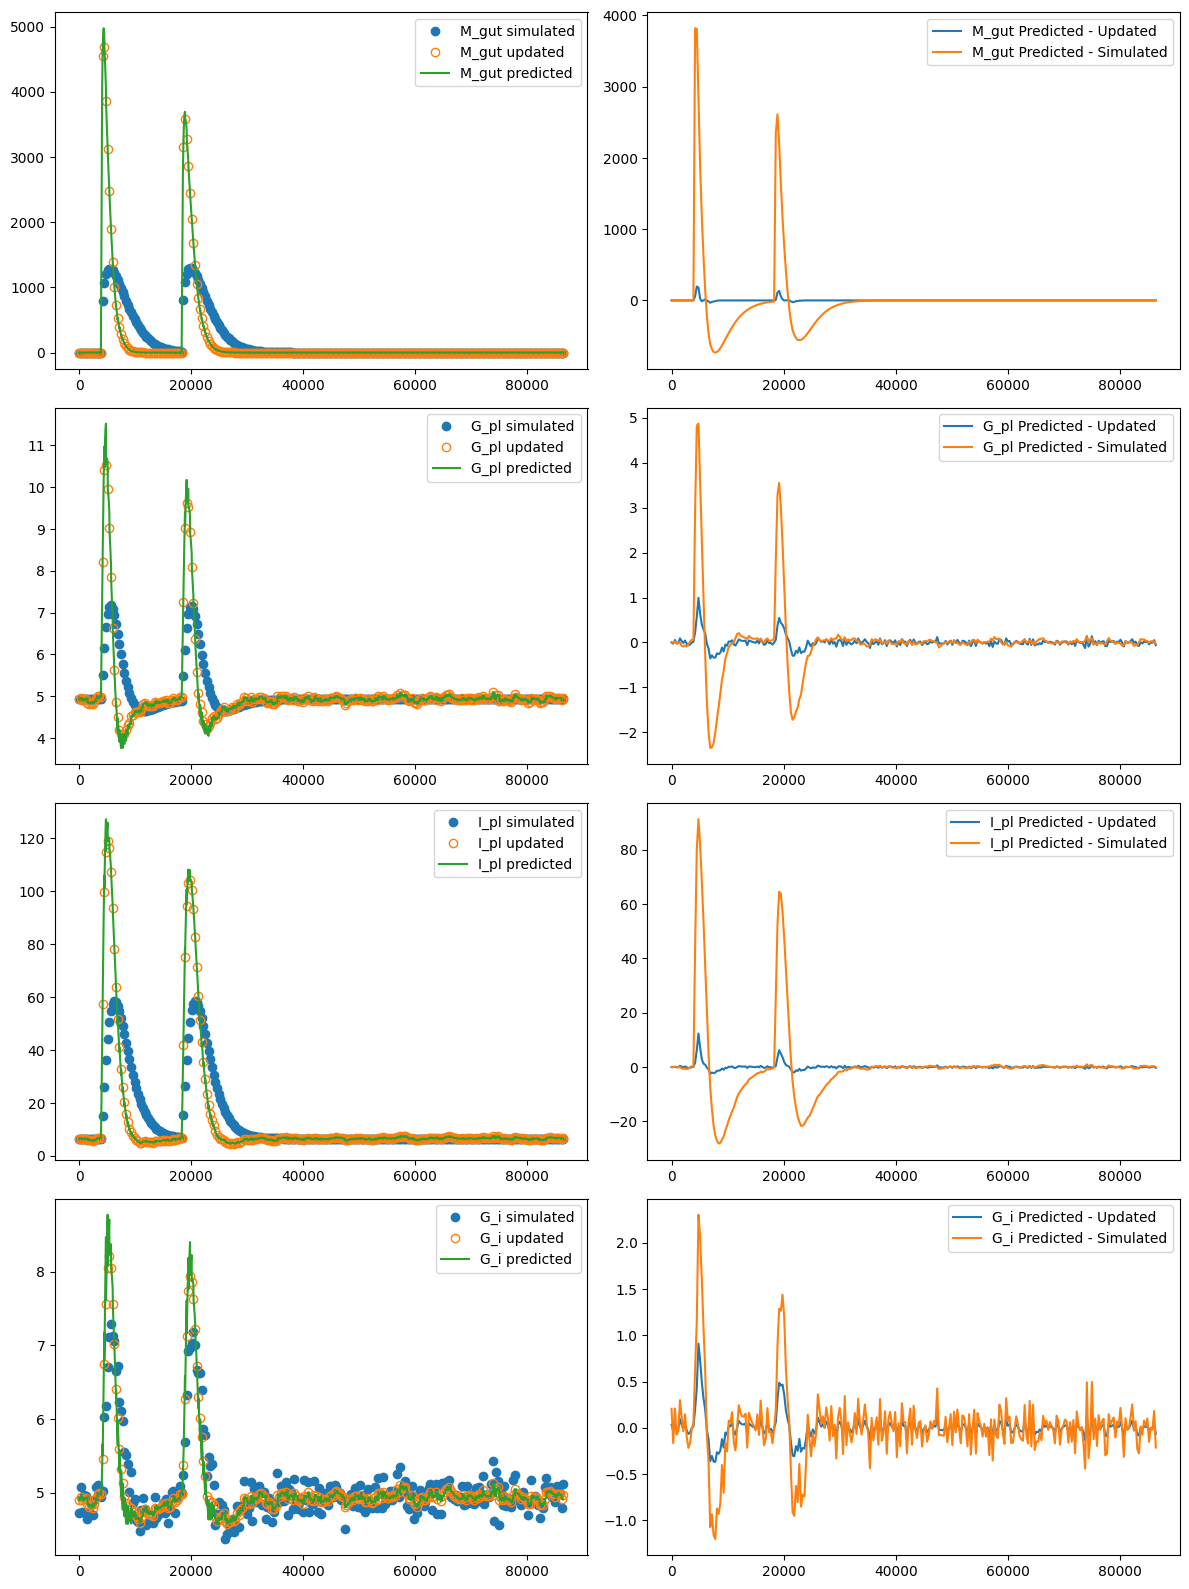

In [104]:
plot_ukf(sim_4sk1taug, x_upd_4sk1taug, x_pred_4sk1taug, t_eval, time_4sk1taug)

In [105]:
#geschätztes k1 umrechnen in Zeitformat
k1_est_2 = (a_k1 + b_k1)/2 + (b_k1 - a_k1)/np.pi*np.arctan(x_pred_4sk1taug[:,4])

#geschätztes tau_g umrechnen in Zeitformat
taug_est_2 = (a_taug + b_taug)/2 + (b_taug - a_taug)/np.pi*np.arctan(x_pred_4sk1taug[:,5])

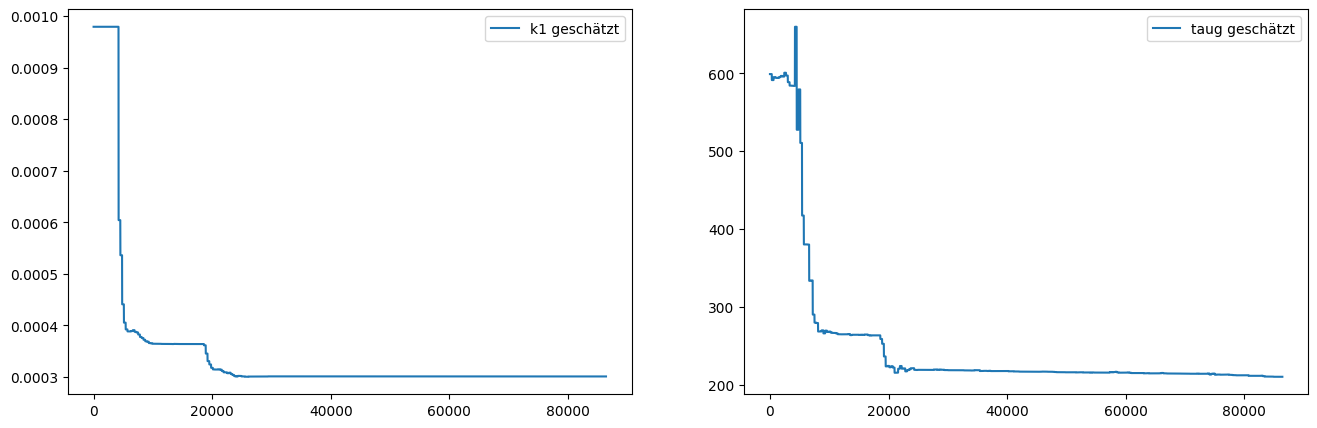

In [106]:
fig, ax = plt.subplots(1,2, figsize = (16, 5))

ax[0].plot(time_4sk1taug, k1_est, label = "k1 geschätzt")
ax[1].plot(time_4sk1taug, taug_est, label = "taug geschätzt")
ax[0].legend()
ax[1].legend()

In [107]:
min_k1_2, max_k1_2 = np.min(k1_est_2), np.max(k1_est_2)
err_k1_2 = (delta_k1+param.k1)/k1_est[-1] #Vergleich Schätzung mit tatsächlichem Wert der Simulation

min_taug_2, max_taug_2 = np.min(taug_est_2), np.max(taug_est_2)
err_taug_2 = (delta_tau_g+param.tau_g)/taug_est_2[-1] #Vergleich Schätzung mit tatsächlichem Wert der Simulation

print(f"(Max, Min) k1: ({max_k1}, {min_k1}), (Max, Min) taug: ({max_taug_2}, {min_taug_2})")
print(f"Parameter der Simulation/ Parameter geschätzt: k1_sim/k1_pred = {err_k1_2}; taug_sim/taug_pred = {err_taug_2}")

(Max, Min) k1: (0.0009789960122032937, 0.0003005524892873454), (Max, Min) taug: (623.9127148954873, 601.3802787125934)
Parameter der Simulation/ Parameter geschätzt: k1_sim/k1_pred = 0.8217652822277378; taug_sim/taug_pred = 0.28869492168892547


### Gemeinsame Schätzung von k1 und k5

In [108]:
from Test_UKF_ode_Dt_tan_k1k5 import f_odes_Dt_tan_k1k5

In [109]:
def iterate_euler_k1k5(y_in: np.ndarray, delta_t: float, inputs: tuple):
    '''Euler-Approximation der Integrationsfunktionen für EDES-Gleichungen'''
    t_current, D_meal = inputs
    y_next = np.zeros(len(y_in))
    dydt = f_odes_Dt_tan_k1k5(y_in, t_current, D_meal)
    y_next = y_in + dydt*delta_t
    return y_next

In [110]:
#Prozessrauschen
Q_4sk1k5 = np.diag([
    1e-4,   # M_gut
    5e-3,   # G_pl
    5e-4,   # I_pl
    5e-3,   # G_i
    5e-5, # p_k1
    5e-5, # p_k5
])

#Kovarianz-Matrix P
covar_4sk1k5 = np.diag([
    var_M_gut, #M_gut
    var_G_pl, #G_pl
    var_I_pl, #I_pl
    var_G_i, #G_i 
    0.125, # p_k1
    0.00125, # p_k5
])

In [111]:
a_k1, b_k1 = 1e-7/60, 3e-1/60 #lower und upper bound für Parameter k1
a_k5, b_k5 = 1e-7/60, 1.0/60 #lower und upper bound für Parameter k5

In [112]:
sim_4sk1k5 = sim[:, 0:6]
np.shape(sim_4sk1k5)

(289, 6)

In [113]:
#Spalte 4 und 5 mit dem parametrisierten Wert von k5 ersetzen
#Die Ausgabe in der Simulation enthält nur die Differenz zum Literaturwert. 
#Für eine korrekte Berechnung des Fehlerwerts muss also das simulierte k1 und k5 reparametrisiert werden,
#damit es mit der Ausgabe des UKF verglichen werden kann.
sim_4sk1k5[:,4]= param.k1+delta_k1 #effektives k1 der Simulation berechnen
#sim_4sk1k5[:,4]= param.k1 #effektives k1 des Literaturwerts einfügen
sim_4sk1k5[:,4] = np.pi*(np.tan(sim_4sk1k5[:,4])-np.tan((a_k1+b_k1)/2))/(b_k1-a_k1) #mit reparametrisiertem Wert ersetzen

sim_4sk1k5[:,5]= param.k5+delta_k5 #effektives k5 der Simulation berechnen
#sim_4sk1k5[:,5]= param.k5 #effektives k5 des Literaturwerts einfügen
sim_4sk1k5[:,5] = np.pi*(np.tan(sim_4sk1k5[:,5])-np.tan((a_k5+b_k5)/2))/(b_k5-a_k5) #mit reparametrisiertem Wert ersetzen

In [114]:
#Startwert p_k1 für k1 berechnen
#Ziel: UKF soll k1 schätzen, die anderen Parameter bleiben ungeschätzt (fix codiert in der Gleichungsfunktion)
#Die Schätzung erfolgt über einen unbeschränkten Hilfsparameter p_k1, der mittels einer 
#arctan-basierten Reparametrisierung auf den beschränkten Parameter k1∈[a_k1,b_k1] abgebildet wird.
# k1 = (b_k1 - a_k1)/pi * atan(p_k1) + (a_k1 + b_k1)/2, mit a_k1, b_k1 = lower und upper bound
# daraus folgt: p_k1 = pi(tan(k1) - tan((a_k1+b_k1)/2))/(b_k1-a_k1) für den Startwert von p_k1

p_k1 = np.pi*(np.tan(param.k1+delta_k1)-np.tan((a_k1+b_k1)/2))/(b_k1-a_k1) #p_k1 für simulatiertes k1
#p_k1 = np.pi*(np.tan(param.k1)-np.tan((a_k1+b_k1)/2))/(b_k1-a_k1) #p_k1 für k1 = Literaturwert
p_k1

#Startwert p_k5 für k5 berechnen
#Ziel: UKF soll k5 schätzen, die anderen Parameter bleiben ungeschätzt (fixe Werte in der Gleichungsfunktion)
#Die Schätzung erfolgt über einen unbeschränkten Hilfsparameter p_k5, der mittels einer 
#arctan-basierten Reparametrisierung auf den beschränkten Parameter taug∈[a_taug,b_taug] abgebildet wird.
# taug = (b_taug - a_taug)/pi * atan(p_taug) + (a_taug + b_taug)/2, mit a_taug, b_taug = lower und upper bound
# daraus folgt: p_taug = pi(tan(taug) - tan((a_taug+b_taug)/2))/(b_taug-a_taug) für den Startwert von p_taug

p_k5 = np.pi*(np.tan(param.k5+delta_k5)-np.tan((a_k5+b_k5)/2))/(b_k5-a_k5) #p_k1 für simulatiertes k1
#p_k5 = np.pi*(np.tan(param.k5)-np.tan((a_k5+b_k5)/2))/(b_k5-a_k5) #p_taug für tau_g = Literaturwert
p_k5

-1.5565073390443607

In [115]:
p_k1

-1.4152917551334008

In [116]:
y_4sk1k5 = np.array([0, #M_gut_start
            G_start, #G_pl_start
            I_start, #I_pl_start
            G_start, #G_i_start
            p_k1, # parametrisierter Startwert für k1
            p_k5 ]) #parametrisierter Startwert für k5

In [117]:
#num_states, process_noise, initial_state, initial_covar, alpha, k, beta, iterate_function
params_4sk1k5 = {
    "num_states" : 6,
    "process_noise" : Q_4sk1k5,
    "initial_state" : y_4sk1k5,
    "initial_covar" : covar_4sk1k5,
    "alpha" : 1e-3, #Standardwert
    "k": 0, #Standardwert
    "beta" : 2.0, # Standardwert
    "iterate_function" : iterate_euler_k1k5
}

In [118]:
#UKF für 4 Zustände, k1, k5
estimator_4sk1k5 = UKF(**params_4sk1k5)

#Schrittgrösse
step_4sk1k5 = 12 #in [s]
x_pred_4sk1k5 = np.zeros((int(24*3600/step_4sk1k5 + 1),6))
x_upd_4sk1k5 = np.zeros((len(data),6))
time_4sk1k5 = np.arange(1, 24*3600+2, step_4sk1k5)

In [119]:
pred_upd(x_pred_4sk1k5, data, x_upd_4sk1k5, D_in_mealtime, estimator_4sk1k5, step_4sk1k5)

In [120]:
sim_4sk1k5 = sim[:, 0:6]
np.shape(sim_4sk1k5)

(289, 6)

In [121]:
#Spalte 4 und 5 mit dem parametrisierten Wert von k1 und k5 ersetzen
#Die Ausgabe in der Simulation enthält nur die Differenz zum Literaturwert. 
#Für eine korrekte Berechnung des Fehlerwerts muss also das simulierte k1 und taug reparametrisiert werden,
#damit es mit der Ausgabe des UKF verglichen werden kann.
sim_4sk1k5[:,4]= param.k1+delta_k1 #effektives k1 der Simulation berechnen
#sim_4sk1k5[:,4]= param.k1 #effektives k1 des Literaturwerts einfügen
sim_4sk1k5[:,4] = np.pi*(np.tan(sim_4sk1taug[:,4])-np.tan((a_k1+b_k1)/2))/(b_k1-a_k1) #mit reparametrisiertem Wert ersetzen

sim_4sk1k5[:,5]= param.k5+delta_k5 #effektives k5 der Simulation berechnen
#sim_4sk1k5[:,5]= param.tau_g #effektives k5 des Literaturwerts einfügen
sim_4sk1k5[:,5] = np.pi*(np.tan(sim_4sk1k5[:,5])-np.tan((a_k5+b_k5)/2))/(b_k5-a_k5) #mit reparametrisiertem Wert ersetzen

In [122]:
x_pred_4sk1k5_masked = mask_data(time_4sk1k5, t_eval, x_pred_4sk1k5)
comp_pred_sim_4sk1k5 = x_pred_4sk1k5_masked-sim_4sk1k5

array([[ 9.20443472e+07,  2.95965581e+01,  6.05583753e+04,
         2.89992257e+01,  4.64181912e+09,  1.99646105e-02],
       [ 5.64351443e+02,  3.20015993e-01,  1.44756537e+01,
         3.16770171e-01,  4.00769982e+03,  8.31154001e-03],
       [ 1.79940115e+02,  1.26486955e-01,  5.96586203e+00,
         1.95446145e-01,  4.00769982e+03,  7.45414984e-03],
       [ 2.09473886e+00, -5.24881568e-02, -5.96042491e+00,
        -5.33328664e-02,  4.00769982e+03, -7.44715863e-03]])

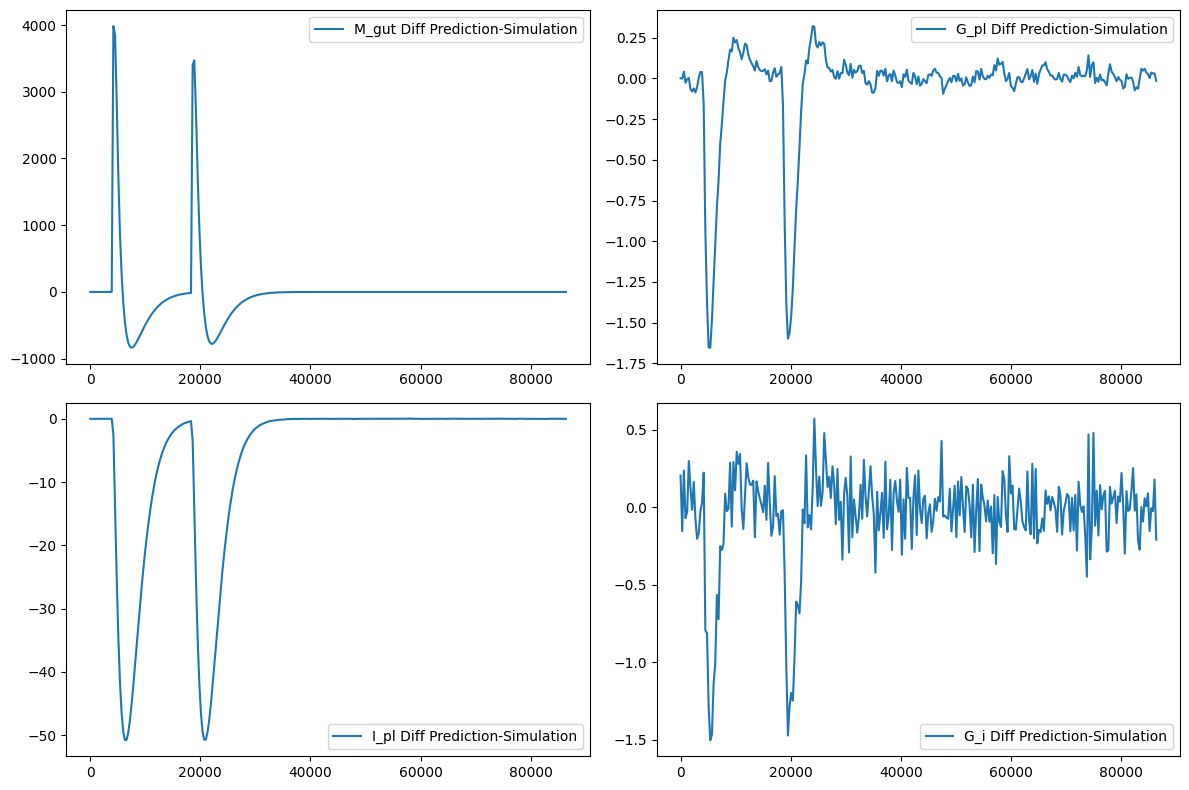

In [123]:
estimate_error(comp_pred_sim_4sk1k5, t_eval)

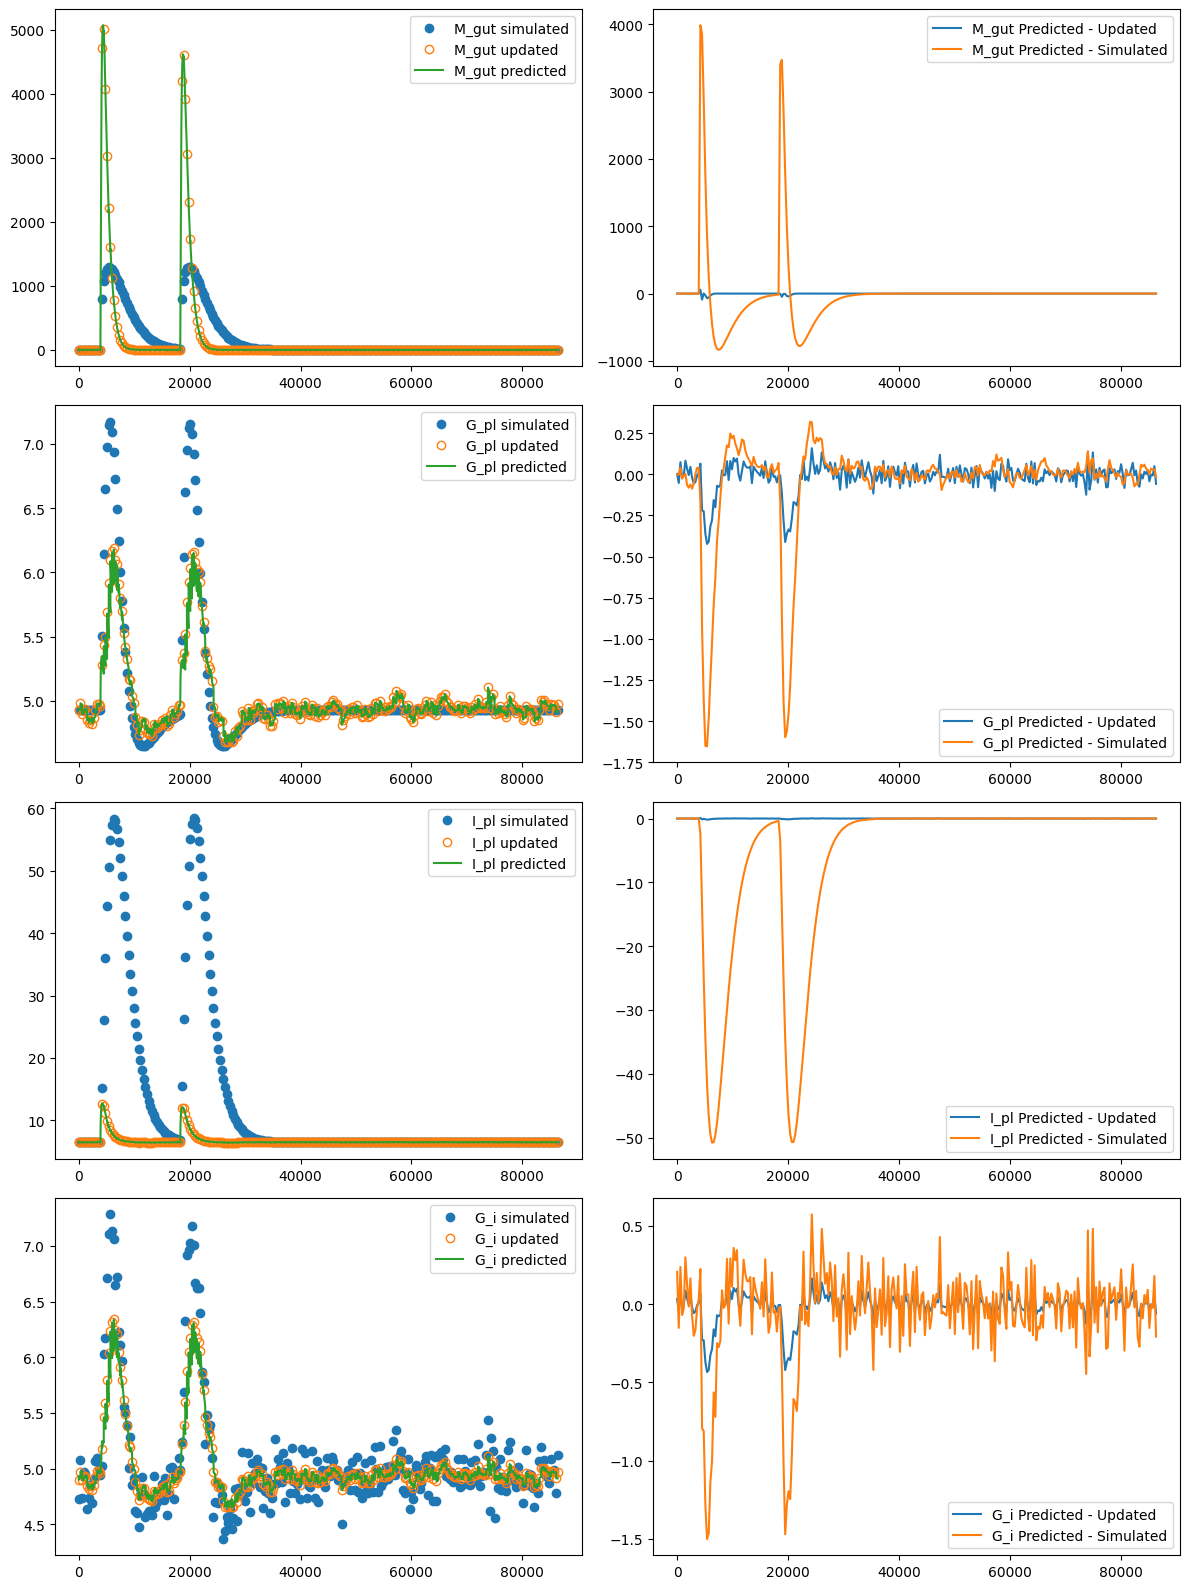

In [124]:
plot_ukf(sim_4sk1k5, x_upd_4sk1k5, x_pred_4sk1k5, t_eval, time_4sk1k5)

In [125]:
#geschätztes k1 umrechnen in Zeitformat
k1_est_2 = (a_k1 + b_k1)/2 + (b_k1 - a_k1)/np.pi*np.arctan(x_pred_4sk1k5[:,4])

#geschätztes k5 umrechnen in Zeitformat
k5_est_2 = (a_k5 + b_k5)/2 + (b_k5 - a_k5)/np.pi*np.arctan(x_pred_4sk1k5[:,5])

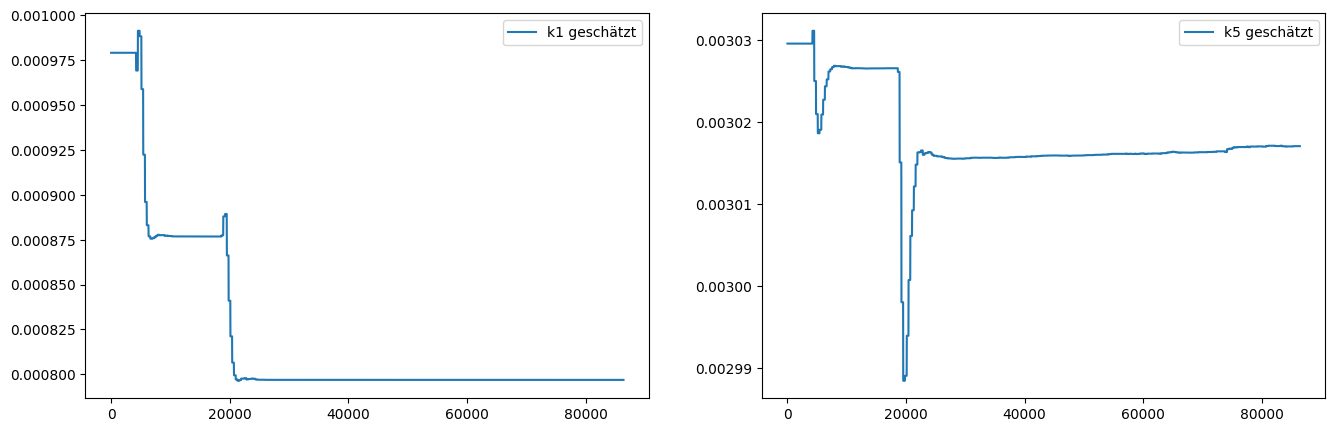

In [126]:
fig, ax = plt.subplots(1,2, figsize = (16, 5))

ax[0].plot(time_4sk1k5, k1_est_2, label = "k1 geschätzt")
ax[1].plot(time_4sk1k5, k5_est_2, label = "k5 geschätzt")
ax[0].legend()
ax[1].legend()

In [127]:
min_k1_2, max_k1_2 = np.min(k1_est_2), np.max(k1_est_2)
err_k1_2 = (delta_k1+param.k1)/k1_est[-1] #Vergleich Schätzung mit tatsächlichem Wert der Simulation

min_k5_2, max_k5_2 = np.min(k5_est_2), np.max(k5_est_2)
err_k5_2 = (delta_k5+param.k5)/k5_est_2[-1] #Vergleich Schätzung mit tatsächlichem Wert der Simulation

print(f"(Max, Min) k1: ({max_k1_2}, {min_k1_2}), (Max, Min) k5: ({max_k5_2}, {min_k5_2})")
print(f"Parameter der Simulation/ Parameter geschätzt: k1_sim/k1_pred = {err_k1_2}; k5_sim/k5_pred = {err_k5_2}")

(Max, Min) k1: (0.000991242031267928, 0.0007964358115190291), (Max, Min) k5: (0.0030311260289551684, 0.0029884862436063272)
Parameter der Simulation/ Parameter geschätzt: k1_sim/k1_pred = 0.8217652822277378; k5_sim/k5_pred = 0.025189983041288683
